In [64]:
import numpy as np
import scipy.io
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import interpolate
from scipy.signal import savgol_filter


import xgboost as xgb
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
import time

%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是黑体的意思
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

### 函数定义

In [79]:
##类方法绘图

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, ticker
from matplotlib.colors import Normalize, LinearSegmentedColormap
import subprocess,os
class SetFig:
    def __init__(self, column,font=0):
        self.column = column  # 设置栏数
        self.cmap = None
        self.font = font
        self.setup_figure_style()
        # 浅色
        colors_rgb = [[75, 116, 178], [144, 190, 224], [230, 241, 243],
                      [255, 223, 146], [252, 140, 90], [219, 49, 36], [106, 168, 79]]
#         colors_rgb = [
#             [75, 116, 178],  # 蓝色
#             [144, 190, 224],  # 浅蓝
#             [230, 241, 243],  # 非常浅的蓝
#             [255, 223, 146],  # 浅橙
#             [252, 140, 90],  # 橙色
#             [219, 49, 36],  # 红色
#             [106, 168, 79]  # 绿色
#         ]
        self.colors = np.array(colors_rgb) / 255.0
        if self.column == 4:
            self.fig, axs = plt.subplots(2, 2, figsize=(12, 10))
            self.ax1, self.ax2, self.ax3, self.ax4 = axs.flatten()
            plt.subplots_adjust(left=0.1, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
        elif self.column == 1:
            self.fig = plt.figure(figsize=(6, 5))
#             plt.subplots_adjust(left=0.1, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
        elif self.column == 4_3:
            self.fig, axes = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(12, 10),tight_layout=True)
            self.ax1, self.ax2, self.ax3, self.ax4 = axes.flatten()
            plt.subplots_adjust(left=0.1, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
#         elif self.column == 2:
#             self.fig = plt.figure(figsize=(14, 6) 
        elif self.column == 2_12:
            self.fig, axs = plt.subplots(1, 2, figsize=(15, 5),dpi=300)
            self.ax1, self.ax2 = axs.flatten()
            plt.subplots_adjust(left=0.1, bottom=0.1, top=0.9, wspace=0.3, hspace=0.4)
        elif self.column == 2_21:
            self.fig, axs = plt.subplots(2, 1, figsize=(12, 10),dpi=300)
            self.ax1, self.ax2 = axs.flatten()
            plt.subplots_adjust(left=0.1, bottom=0.1, top=0.9, wspace=0.3, hspace=0.4)
        else:
            print("error column")
                                  
    def setup_figure_style(self):
        if self.font !=1:
            plt.rcParams['figure.dpi'] = 300
            plt.rcParams['font.sans-serif'] = ['SimHei']
            plt.rcParams['axes.unicode_minus'] = False
            plt.rcParams['font.weight'] = 'light'
            plt.rcParams['axes.titlesize'] = 14
            plt.rcParams['axes.labelsize'] = 14
            plt.rcParams['xtick.labelsize'] = 12
            plt.rcParams['ytick.labelsize'] = 12
            plt.rcParams['xtick.major.pad'] = 6
            plt.rcParams['ytick.major.pad'] = 6
            plt.rcParams['legend.fontsize'] = 10
            plt.rcParams['axes.titlepad'] = -20
            plt.rcParams['axes.linewidth'] = 1
            plt.rcParams['axes.edgecolor'] = 'black'
            plt.rcParams['xtick.direction'] = 'in'
            plt.rcParams['ytick.direction'] = 'in'
            plt.rcParams['savefig.format'] = 'svg'
            plt.rcParams['figure.autolayout'] = False
        if self.font ==1:
            plt.rcParams['figure.dpi'] = 300
            plt.rcParams['font.sans-serif'] = ['SimHei']
            plt.rcParams['axes.unicode_minus'] = False
            plt.rcParams['font.weight'] = 'light'
            plt.rcParams['axes.titlesize'] = 20
            plt.rcParams['axes.labelsize'] = 20
            plt.rcParams['xtick.labelsize'] = 18
            plt.rcParams['ytick.labelsize'] = 18
            plt.rcParams['xtick.major.pad'] = 6
            plt.rcParams['ytick.major.pad'] = 6
            plt.rcParams['legend.fontsize'] = 20
            plt.rcParams['axes.titlepad'] = -20
            plt.rcParams['axes.linewidth'] = 1
            plt.rcParams['axes.edgecolor'] = 'black'
            plt.rcParams['xtick.direction'] = 'in'
            plt.rcParams['ytick.direction'] = 'in'
            plt.rcParams['savefig.format'] = 'svg'
            plt.rcParams['figure.autolayout'] = False
    def create_cmap(self, n):
        colors_rgb = [[75, 116, 178], [144, 190, 224], [255, 223, 146], [219, 49, 36]]
        colors = np.array(colors_rgb) / 255.0
        self.cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n)
        return self.cmap
    
    def create_colorbar(self, cmap=None, norm=None, ticks=None, boundaries=None, label=None):
        plt.subplots_adjust(left=0.1, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
        self.fig.subplots_adjust(right=0.9)
        if self.column == 1:
            cbar_ax = self.fig.add_axes([0.94, 0.1, 0.04, 0.8])  # 设置颜色条的位置
        elif self.column == 4 :
            cbar_ax = self.fig.add_axes([0.94, 0.1, 0.02, 0.8])  # 设置颜色条的位置
        elif self.column == 4_3:
            self.fig.subplots_adjust(right=0.80)
            cbar_ax = self.fig.add_axes([0.97, 0.1, 0.02, 0.8])  # 设置颜色条的位置
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = self.fig.colorbar(sm, cax=cbar_ax, location='right', ticks=ticks, boundaries=boundaries, pad=0.02)
        cbar.set_label(label, fontsize=14)
        cbar.ax.tick_params(labelsize=12)
    
#     @property    
    def plot_as_emf(self,**kwargs):
#     plot_as_emf[fig,filename = '.emf']
        figure = self.fig 
        inkscape_path = kwargs.get('inkscape', r"D:\Program Files\Inkscape\bin\inkscape.exe")

        filepath = kwargs.get('filename', None)

        if filepath is not None:
            path, filename = os.path.split(filepath)
            filename, extension = os.path.splitext(filename)
            svg_filepath = os.path.join(path, filename+'.svg')
            emf_filepath = os.path.join(path, filename+'.emf')
            figure.savefig(svg_filepath, format='svg',bbox_inches='tight')
            subprocess.call([inkscape_path, svg_filepath, '--export-emf', emf_filepath])

#             os.remove(svg_filepath)
    def save(self, name=None, pad_inches=None):
        if name is None:
            name = "default_name"  # 提供一个默认文件名
        # 确保路径以反斜杠结束，且使用.format或f-string来插入文件名
        filepath = r'E:\毕业设计\毕业论文\picture\{}.svg'.format(name)
        # 使用修正后的路径和格式化好的文件名保存文件
        #         self.fig.savefig(filepath, format='svg', bbox_inches='tight', pad_inches=pad_inches)
        if self.column == 1:
            self.fig.savefig(filepath, format='svg')
        else: 
            self.fig.savefig(filepath, format='svg',bbox_inches='tight', pad_inches=pad_inches)
    def saveemf(self,name):
        filename =r'E:\毕业设计\毕业论文\picture\{}.emf'.format(name)
        self.plot_as_emf(filename=filename)
    def show(self):
        if self.cmap ==None:
            plt.tight_layout()
        plt.show()
'''
fig = SetFig(column=1,font=1)
cmap = fig.create_cmap(10)
color = fig.colors
# 在创建的子图上绘图
# 示例：使用 axs 属性绘制子图。注意，这需要在调用 set_fig.show() 之前完成
plt.plot([1, 2, 3], [1, 2, 3])
fig.create_colorbar(cmap=cmap)
fig.show()


fig = SetFig(column=4)
cmap = fig.create_cmap(10)
# 在创建的子图上绘图
# 示例：使用 axs 属性绘制子图。注意，这需要在调用 set_fig.show() 之前完成
fig.ax1.plot([1, 2, 3], [1, 2, 3])
fig.ax2.plot([1, 2, 3], [3, 2, 1])
fig.ax3.plot([1, 2, 3], [2, 1, 3])
fig.ax4.plot([1, 2, 3], [3, 1, 2])

fig.create_colorbar(cmap=cmap)
fig.show()
'''        

'\nfig = SetFig(column=1,font=1)\ncmap = fig.create_cmap(10)\ncolor = fig.colors\n# 在创建的子图上绘图\n# 示例：使用 axs 属性绘制子图。注意，这需要在调用 set_fig.show() 之前完成\nplt.plot([1, 2, 3], [1, 2, 3])\nfig.create_colorbar(cmap=cmap)\nfig.show()\n\n\nfig = SetFig(column=4)\ncmap = fig.create_cmap(10)\n# 在创建的子图上绘图\n# 示例：使用 axs 属性绘制子图。注意，这需要在调用 set_fig.show() 之前完成\nfig.ax1.plot([1, 2, 3], [1, 2, 3])\nfig.ax2.plot([1, 2, 3], [3, 2, 1])\nfig.ax3.plot([1, 2, 3], [2, 1, 3])\nfig.ax4.plot([1, 2, 3], [3, 1, 2])\n\nfig.create_colorbar(cmap=cmap)\nfig.show()\n'

In [3]:
# 转换时间格式，将字符串转换成 datatime 格式
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(
        hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# 加载 mat 文件
# 这个函数加载了一个MATLAB格式的文件（.mat文件），提取了其中的数据，并将其转换为一个Python数据结构。
# 具体地，它从MAT文件中提取了一个特定的字段，然后将其组织为一个包含字典的列表，每个字典代表一个数据点。
# 字典的键包括 'type'、'temp'、'time' 和 'data'，分别表示数据类型、温度、时间和实际数据。这个函数返回一个包含这些字典的列表。
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split('/')[-1].split('.')[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0]
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(
            col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# 提取锂电池容量
# 这个函数接受一个表示锂电池测试数据的列表 Battery，从中提取出放电过程的电池容量和循环数。
# 返回一个包含循环数和容量的列表。
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# 获取锂电池充电或放电时的测试数据
# 这个函数接受一个表示锂电池测试数据的列表 Battery 和一个字符串参数 Type（默认为 'charge'），
# 从中提取出充电或放电过程的测试数据，并返回一个包含这些数据的列表。
def getBatteryValues(Battery, Type='charge'):
    data = []
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data


def arrhenius_equation(T, t):
    A = 720.3429729  # 频率因子
    E_a_Ratio_R = 3162.3225  # 活化能 (J/mol)
    z = 0.7812079
    k = A * math.exp(-E_a_Ratio_R/(T + 273.15))*t**z
    return k

### 加载数据集

In [51]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']  # 4 个数据集的名字
dir_path = 'dataset/'
# Battery_list = ['B0025', 'B0026', 'B0027', 'B0028']  # 4 个数据集的名字
# dir_path = r'E:\毕业设计\soc\资料\NASA锂电池试验数据\5. Battery Data Set\2. BatteryAgingARC_25_26_27_28_P1/' #r'D:\embed_work\python_project\RealCar_SOH\feature_data/'
capacity, charge, discharge = {}, {}, {}
# 逐个获取电芯的数据
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    capacity[name] = getBatteryCapacity(
        data
    )  # 放电时的容量数据 返回一个包含循环数和容量的列表 capacity[name][0]为循环次数，capacity[name][1]为容量。
    charge[name] = getBatteryValues(data, 'charge')  # 充电数据 返回一个包含充电数据的列表。
    discharge[name] = getBatteryValues(
        data, 'discharge')  # 放电数据 返回一个包含放电数据的列表，列表元素为字典。

# print(capacity['B0005'][:5])
# print(len(charge['B0005']))
# print(len(discharge['B0005']))
# print(len(charge['B0006']))
# print(len(discharge['B0006']))
# print(len(charge['B0007']))
# print(len(discharge['B0007']))

Load Dataset B0005.mat ...
Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


### 特征工程

#### 提取ICAPI特征

In [7]:
charge_data = charge['B0005']

Voltage = np.array(charge_data['Voltage_measured'])
Current = np.array(charge_data['Current_measured'])
time = np.array(charge_data['Time'])

In [228]:
value1 = 3.88
value2 = 3.95
value3 = 3.95
value4 = 4.10

dv_dt1_list = {}
dv_dt2_list = {}

# Data_ = charge['B0005']

for name in Battery_list:
    Data_ = charge[name]
    feature1 = []
    feature2 = []
    for i in range(1,len(Data_)):
        charge_data = Data_[i]
        Voltage = np.array(charge_data['Voltage_measured'])
        Current = np.array(charge_data['Current_measured'])
        Time = np.array(charge_data['Time'])
    #     plt.plot()
    #     charge_Capacity = np.array(charge_data['q'])
        data = np.column_stack((Voltage, Time))

        # 筛选出第一个电压范围内的数据
        index2 = np.where((data[:, 0] >= value1) & (data[:, 0] <= value2))[0]
        data1 = data[index2, :]
        Seq_min = np.min(data1[:, 1])
        Seq_max = np.max(data1[:, 1])
        data2 = Seq_max - Seq_min

        feature1.append(data2)

        # 筛选出第二个电压范围内的数据
        index3 = np.where((data[:, 0] >= value3) & (data[:, 0] <= value4))[0]
        data3 = data[index3, :]
        Seq_min1 = np.min(data3[:, 1])
        Seq_max1 = np.max(data3[:, 1])
        data4 = Seq_max1 - Seq_min1
        feature2.append(data4)
        
    feature1= np.array(feature1)
    feature2= np.array(feature2)
    dv_dt1_list[name] = feature1
    dv_dt2_list[name] = feature2
    

In [155]:
dv_dt1_list['B0018']

array([509.594, 608.75 , 607.25 , 553.453, 682.937, 679.984, 670.14 ,
       663.234, 541.609, 674.813, 676.437, 661.844, 647.687, 574.781,
       647.328, 651.797, 642.297, 627.734, 586.344, 593.282, 586.735,
       580.656, 573.844, 465.438, 606.547, 612.281, 610.188, 589.657,
       554.797, 569.219, 563.64 , 558.047, 556.609, 507.985, 530.296,
       520.938, 508.891, 510.171, 389.86 , 544.375, 530.157, 508.953,
       495.047, 427.422, 475.796, 623.406, 602.344, 584.875, 569.125,
       508.25 , 567.453, 546.687, 531.984, 515.781, 427.454, 554.406,
       533.704, 513.75 , 501.218, 439.531, 478.969, 472.469, 461.547,
       456.234, 379.938, 445.047, 428.39 , 426.766, 421.609, 254.282,
       443.39 , 431.031, 420.297, 413.281, 314.109, 408.531, 401.063,
       397.328, 385.578, 281.969, 378.312, 376.297, 372.391, 369.063,
       158.937, 393.61 , 380.515, 371.578, 367.313, 163.015, 377.078,
       368.407, 359.422, 356.031, 249.578, 354.015, 343.765, 339.781,
       333.64 , 220.

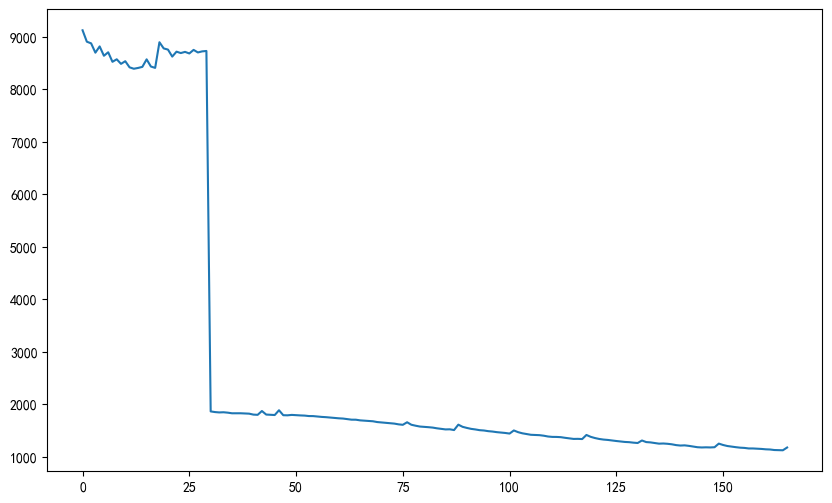

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(dv_dt2_list['B0005'])

In [137]:
len(dv_dt1_list['B0018'])

131

#### dtw_IC特征

In [243]:
def get_ic_curve(data_ch,i):
    #     ic_cruve, Voltage, time, Current = [], [], [], []
    #     ch_cap = np.nan
    #     for cycle in charge_data:
    charge_data = data_ch[i]
    Voltage = np.array(charge_data['Voltage_measured'])
    Current = np.array(charge_data['Current_measured'])
    time = np.array(charge_data['Time'])
    t = np.diff(time)
    ch_cap = np.insert(
        ((Current[:-1] + np.diff(Current) * 0.5) * t / 3600).cumsum(), 0,
        0)
    Data_ = pd.DataFrame({
        'Voltage(V)': Voltage,
        'Current(A)': Current,
        'charge_Capacity(Ah)': ch_cap,
        'Time': time,
        'Capetive': ch_cap
    })
    data = Data_
    data.drop_duplicates(subset='Voltage(V)', keep='first',
                         inplace=True)  # 去重
    y = data['charge_Capacity(Ah)'].values


    data = data.sort_values(by='Voltage(V)')  # 电压排序
    x = data['Voltage(V)'].values
    data_x_y = pd.DataFrame({'Voltage': x, 'charge_Capacity(Ah)': y})
    #         print("before"+str(i))
    #         print(data_x_y)
    data_x_y = data_x_y[data_x_y['Voltage'] <= 4.15]
    #         print("after")
    #         print(data_x_y)

    x = data_x_y['Voltage'].values
    y = data_x_y['charge_Capacity(Ah)'].values
    if len(x) <= 2:
        return get_ic_curve(data_ch,i-1)
    IC_cruve_df = pd.DataFrame({
        'Voltage': x,
        'charge_Capacity(Ah)': y
    })
    
    x_new = np.linspace(max(x), min(x), math.ceil(
        (max(x) - min(x)) / 0.01))  # 电压插值

    f_pchip = interpolate.PchipInterpolator(x, y)  #生成Pchip插值器

    y = pd.Series(f_pchip(x_new))
    x = pd.Series(x_new)
    dv = x.diff(periods=1)
    dq = y.diff(periods=1)
    ic_cruve = np.array(dq / dv)
    ## 移动平均滤波
    window_size = 3  # 窗口大小，您可以根据需要调整这个值
    maf = pd.Series(f_pchip(x_new)).rolling(window=window_size,min_periods=1).mean().values
    maf = pd.Series(maf)
    maf_dq = maf.diff(periods=1)
    maf_ic_cruve = np.array(maf_dq / dv)
    ## SG滤波
    sg = savgol_filter(f_pchip(x_new), 31, 11,
                       mode='nearest')  # 基于插值器和生成的横坐标，生成电压并滤波
    sg = pd.Series(sg)
    sg_dq = sg.diff(periods=1)
    sg_ic_cruve = np.array(sg_dq / dv)
    
    
    IC_cruve_df = pd.DataFrame({
        'Voltage(V)': x,
        'IC_cruve':maf_dq
    })
    return x,maf_ic_cruve

In [52]:
data_ = charge['B0005'][1]
x0,ic_cruve = get_ic_curve(data_)

In [53]:
x0

0      4.149088
1      4.139025
2      4.128963
3      4.118900
4      4.108837
         ...   
110    3.042201
111    3.032138
112    3.022076
113    3.012013
114    3.001951
Length: 115, dtype: float64

In [244]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# def get_ic_curve(data):
#     """这个函数是为了获取IC曲线数据，您需要根据实际情况来实现这个函数"""
#     # 这里只是一个示例
#     return data['time'], data['IC']

def min_max_normalize(data, data_min, data_max):
    """基于整个数据集的最小-最大值进行归一化"""
    return (data - data_min) / (data_max - data_min)

# 假设 Data_ 已经按 Cell 分类并存储在字典中
# Data_ = {'Cell' + str(i): data_list['Cell' + str(i) + '_data'] for i in range(1, 9)}

# 找出所有IC曲线的最大最小值
all_ic_curves = []

for name in Battery_list:
    Data_ = charge[name]
    for i in range(1,len(Data_)):
        x, ic_curve = get_ic_curve(Data_,i)
        clean_ic_curve = ic_curve[~np.isnan(ic_curve)]
        all_ic_curves.extend(clean_ic_curve)

data_min = np.min(all_ic_curves)
data_max = np.max(all_ic_curves)

# 初始化一个字典来存储每个Cell的DTW距离列表
dtw_ic_lists = {}

# 遍历每个Cell
for name in Battery_list:
    Data_ = charge[name]
    x1, ic_curve1 = get_ic_curve(Data_,1)
    clean_ic_curve1 = ic_curve1[~np.isnan(ic_curve1)]
    normalized_ic_curve1 = min_max_normalize(clean_ic_curve1, data_min, data_max)
    dtw_ic_list = [0]  # 初始化当前Cell的DTW距离列表

    # 遍历当前Cell的所有IC曲线（除了第一条）
    for i in range(2, len(Data_)):
        xi, ic_curvei = get_ic_curve(Data_,i)
        clean_ic_curvei = ic_curvei[~np.isnan(ic_curvei)]
        normalized_ic_curvei = min_max_normalize(clean_ic_curvei, data_min, data_max)
        dtw_ic, path = fastdtw(normalized_ic_curve1, normalized_ic_curvei)
        dtw_ic_list.append(dtw_ic)  # 将计算得到的DTW距离添加到列表中

    # 将当前Cell的DTW距离列表转换为numpy数组并存储到字典中
    dtw_ic_lists[name] = np.array(dtw_ic_list)

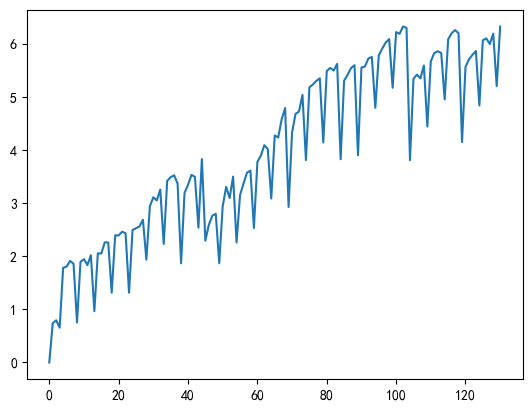

In [134]:
plt.plot(dtw_ic_lists['B0018'])

In [143]:
len(dtw_ic_lists['B0005'])

166

In [ ]:
        # 清除nan
        df = pd.DataFrame(all_data, columns=['time', 'Voltage'])

        # 删除包含NaN的行
        df = df.dropna()

        # 如果需要，可以将处理后的数据转回numpy数组
        time_clean = df['Time'].to_numpy()
        voltage_clean = df['Voltage'].to_numpy()

#### DTW-Vt

In [259]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
all_times = []
all_voltages = []
# charge_data = data_ch[i]
for cell_name in Battery_list:
    Data_ = charge[cell_name]
    for i in range(len(Data_)):
        time = np.array(Data_[i]['Time'])  # 时间信息
        voltage = np.array(Data_[i]['Voltage_measured'])  #电压信息
        df = pd.DataFrame({
            'Time': time,
            'Voltage': voltage
        })
        df_clean = df.dropna()
        time= df_clean['Time'].to_numpy()
        voltage = df_clean['Voltage'].to_numpy()
        all_times.extend(time)
        all_voltages.extend(voltage)

        
time_min, time_max = np.min(all_times), np.max(all_times)
voltage_min, voltage_max = np.min(all_voltages), np.max(all_voltages)

# 初始化时间和电压的归一化器
scaler_time = MinMaxScaler().fit(np.array([time_min, time_max]).reshape(-1, 1))
scaler_voltage = MinMaxScaler().fit(np.array([voltage_min, voltage_max]).reshape(-1, 1))

In [262]:
voltage_min

2.8889259226774757

In [263]:
voltage_max

4.2150694402361655

In [266]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
all_times = []
all_voltages = []
# charge_data = data_ch[i]
for cell_name in Battery_list:
    Data_ = charge[cell_name]
    for i in range(1,len(Data_)):
        time = np.array(Data_[i]['Time'])  # 时间信息
        voltage = np.array(Data_[i]['Voltage_measured'])  # 电压信息
        df = pd.DataFrame({
            'Time': time,
            'Voltage': voltage
        })
        df_clean = df.dropna()
        time= df_clean['Time'].to_numpy()
        voltage = df_clean['Voltage'].to_numpy()
        all_times.extend(time)
        all_voltages.extend(voltage)

        
time_min, time_max = np.min(all_times), np.max(all_times)
voltage_min, voltage_max = np.min(all_voltages), np.max(all_voltages)

# 初始化时间和电压的归一化器
scaler_time = MinMaxScaler().fit(np.array([time_min, time_max]).reshape(-1, 1))
scaler_voltage = MinMaxScaler().fit(np.array([voltage_min, voltage_max]).reshape(-1, 1))

# 用于存储所有电池的DTW距离列表
dtw_vtt_list = {}

for cell_name in Battery_list:  # 从 Cell1 到 Cell8
    Data_ = charge[cell_name]
#     Data_list_ = data_list[cell_key]
    time_1 = np.array(Data_[1]['Time'])  # 提取时间信息
    voltage_1 = np.array(Data_[1]['Voltage_measured'])
    df = pd.DataFrame({
            'Time': time_1,
            'Voltage': voltage_1
        })
    df_clean = df.dropna()
    time_1= df_clean['Time'].to_numpy()
    voltage_1 = df_clean['Voltage'].to_numpy()
    # 单独归一化时间和电压
    time_1_scaled = scaler_time.transform(time_1.reshape(-1, 1)).flatten()
    voltage_1_scaled = scaler_voltage.transform(voltage_1.reshape(-1, 1)).flatten()
    V_T_curve_1_scaled = np.column_stack((time_1_scaled, voltage_1_scaled))

    dtw_distances = [0]  # 初始化当前电池的DTW距离列表
    for i in range(2, len(Data_)):
        time_i = np.array(Data_[i]['Time'])  # 时间信息
        voltage_i = np.array(Data_[i]['Voltage_measured'])  # 电压信息
        df = pd.DataFrame({
            'Time': time_i,
            'Voltage': voltage_i
        })
        df_clean = df.dropna()
        time_i= df_clean['Time'].to_numpy()
        voltage_i = df_clean['Voltage'].to_numpy()
        # 单独归一化时间和电压
        time_i_scaled = scaler_time.transform(time_i.reshape(-1, 1)).flatten()
        voltage_i_scaled = scaler_voltage.transform(voltage_i.reshape(-1, 1)).flatten()
        V_T_curve_i_scaled = np.column_stack((time_i_scaled, voltage_i_scaled))
        
        dtw_vt, path = fastdtw(V_T_curve_1_scaled, V_T_curve_i_scaled, dist=euclidean)  # 计算DTW距离
        dtw_distances.append(dtw_vt)
    
    dtw_vtt_list[cell_name] = np.array(dtw_distances)  # 将结果存储到字典中


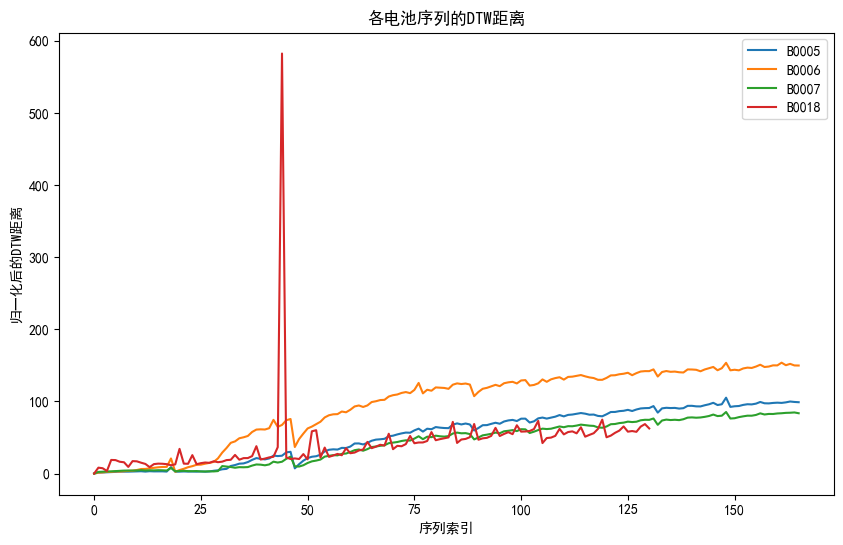

In [267]:
# 绘制每个电池的DTW距离
plt.figure(figsize=(10, 6))
for cell_key, distances in dtw_vtt_list.items():
    plt.plot(distances, label=cell_key)
plt.legend()
plt.xlabel('序列索引')
plt.ylabel('归一化后的DTW距离')
plt.title('各电池序列的DTW距离')
plt.show()

In [268]:
import pickle

# 假设 dtw_vtt_list 是您要保存的数据
# dtw_vtt_list = {...}
# 将数据保存到文件
with open('.\output\DTW_Vt\dtw_vtt_list_new.pkl', 'wb') as file:
    pickle.dump(dtw_vtt_list, file)


In [269]:
import pickle

# 从文件中读取数据
with open('.\output\DTW_Vt\dtw_vtt_list_new.pkl', 'rb') as file:
    dtw_vtt_list_loaded = pickle.load(file)

# 现在 dtw_vtt_list_loaded 包含原始 dtw_vtt_list 中的数据

In [27]:
##test arrhenius
arrhenius_equation(24,100)

0.6282275176489713

### 特征分析

#### dtwic

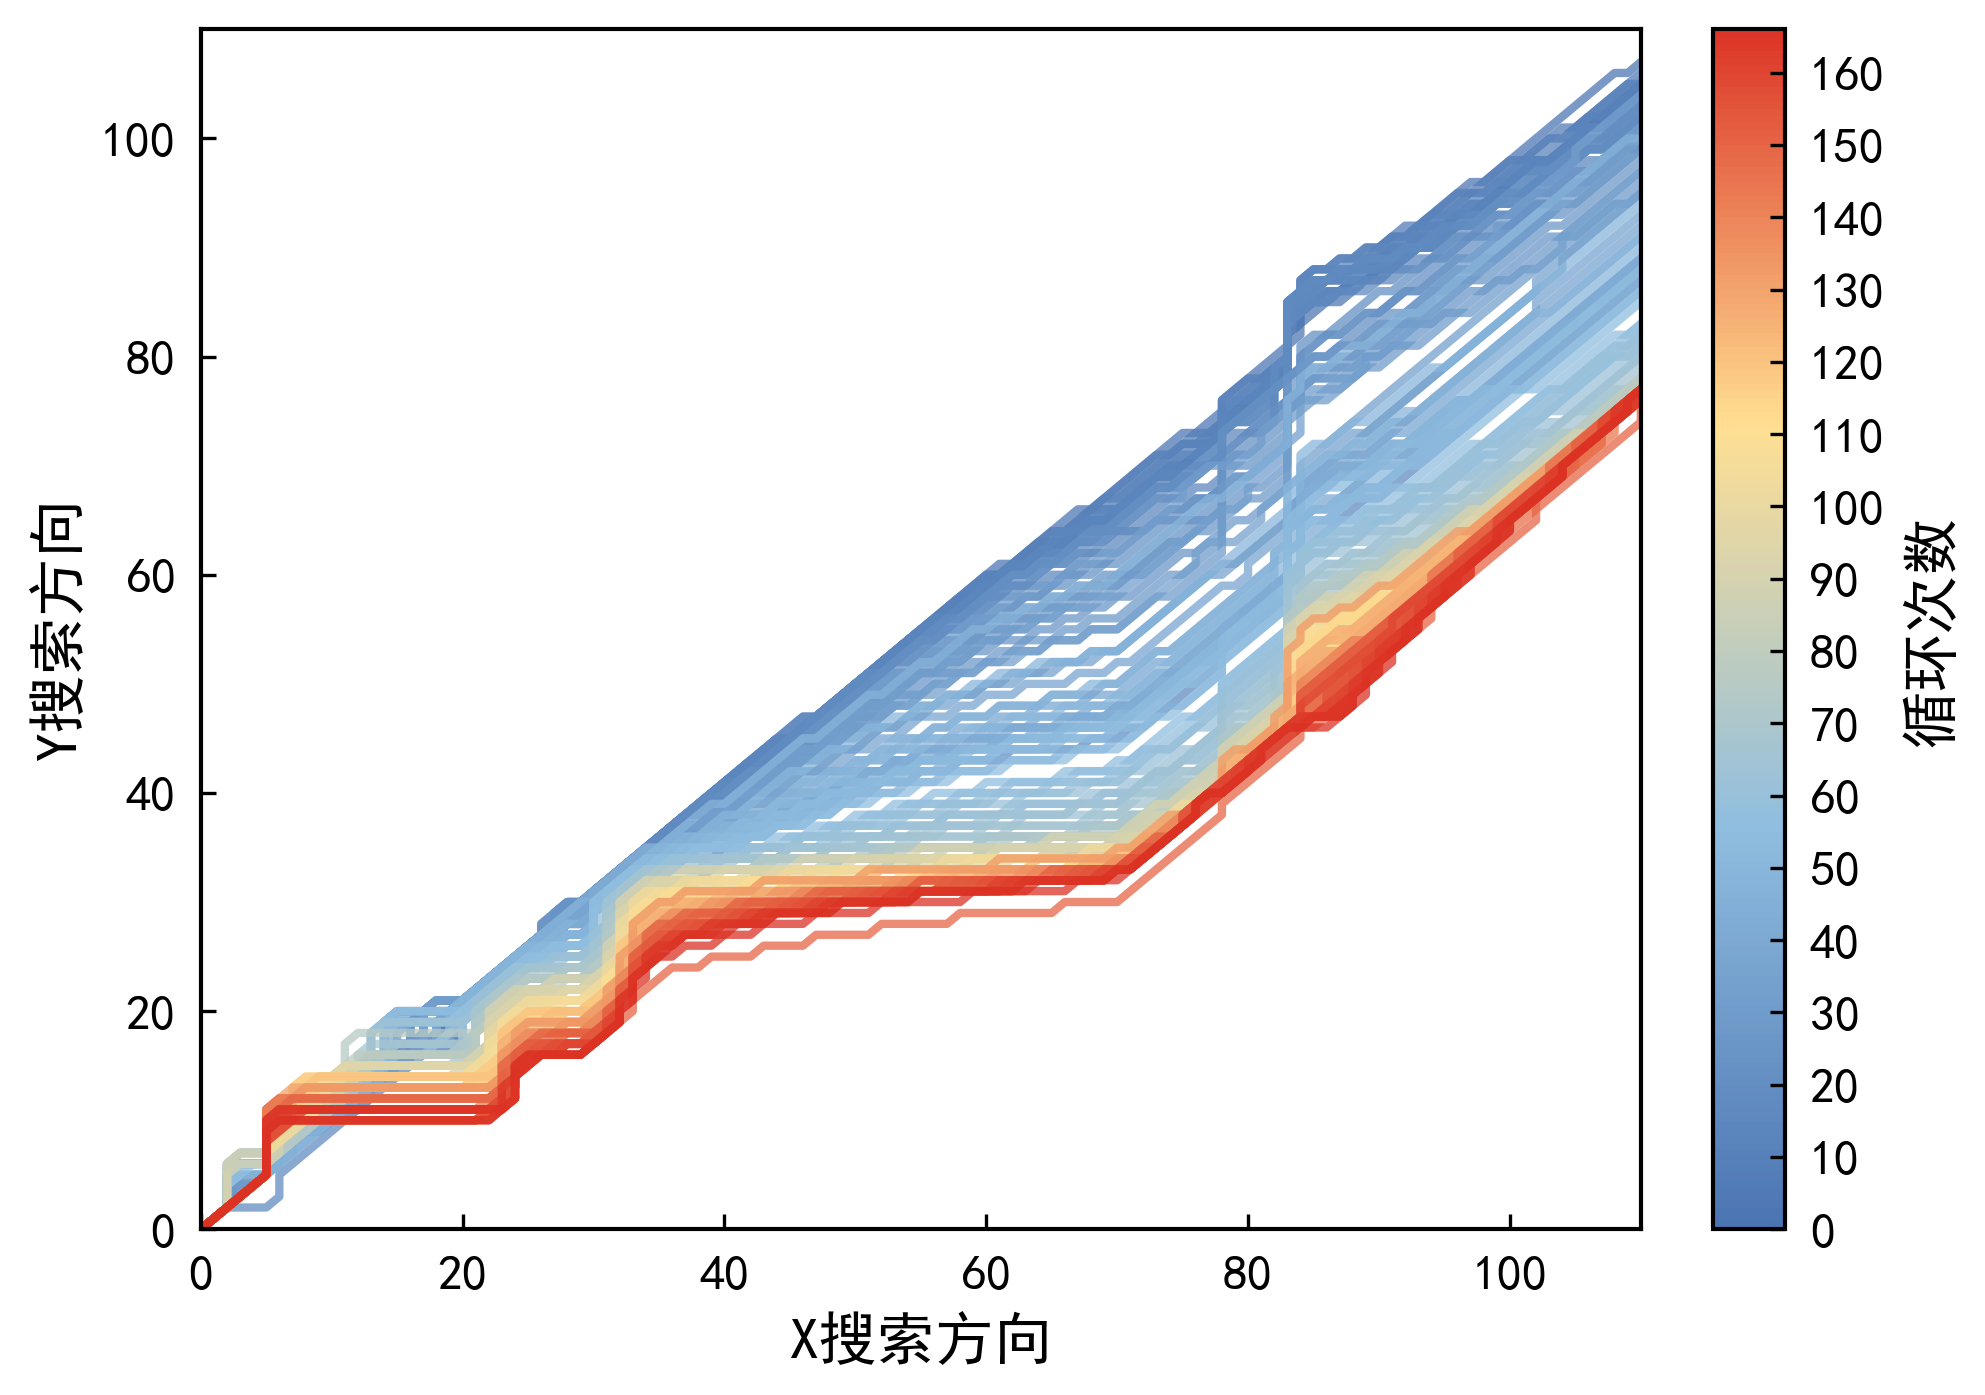

In [293]:
import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw
from fastdtw import fastdtw
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib


Data_list_ = charge['B0005']
# 计算并清理模板曲线
# x1, ic_curve1 = get_ic_curve(Data_list_[0])
# clean_ic_curve1 = ic_curve1[~np.isnan(ic_curve1)]

x1, ic_curve1 = get_ic_curve(Data_list_,1)
clean_ic_curve1 = ic_curve1[~np.isnan(ic_curve1)]
# normalized_ic_curve1 = min_max_normalize(clean_ic_curve1, data_min, data_max)

fig = SetFig(column=1)

# 定义颜色

cycles = len(Data_list_)


# 创建一个自定义的颜色映射对象
cmap = fig.create_cmap(cycles)

for i in range(2, cycles):
    xi, ic_curvei = get_ic_curve(Data_list_,i)
    clean_ic_curvei = ic_curvei[~np.isnan(ic_curvei)]
    
    # 计算最优路径
    distance, paths = dtw.warping_paths(clean_ic_curve1, clean_ic_curvei, window=50, use_pruning=True)
    best_path = dtw.best_path(paths)
    
    # 获取路径矩阵的行和列索引
    path_x, path_y = zip(*best_path)
    
    # 绘制最优路径
    plt.plot(path_x, path_y,color=cmap(i/cycles), linewidth=2, alpha=0.75)

# 绘制对角线（模板曲线自比）
# plt.plot(range(max(len(clean_ic_curve1), len(xi))), range(max(len(clean_ic_curve1), len(xi))), label='Diagonal (Template)', color='blue', linestyle='--', linewidth=2)

# 设置图例和其他属性
# plt.title('Cell1 IC_V曲线最优规整路径',y=-0.1)
plt.xlabel('X搜索方向')
plt.ylabel('Y搜索方向')
plt.xlim(0,110)
plt.ylim(0,110)
# 创建颜色条
fig.create_colorbar(cmap=cmap,norm=plt.Normalize(vmin=0, vmax=cycles),ticks=np.arange(0, cycles, 10), boundaries=np.arange(0, cycles, 1),label = '循环次数')
# plt.grid(True)
# fig.save('IC_V曲线最优规整路径')
# plt.savefig(r'E:\毕业设计\毕业论文\picture\IC_V曲线最优规整路径.svg', format='svg',bbox_inches='tight')

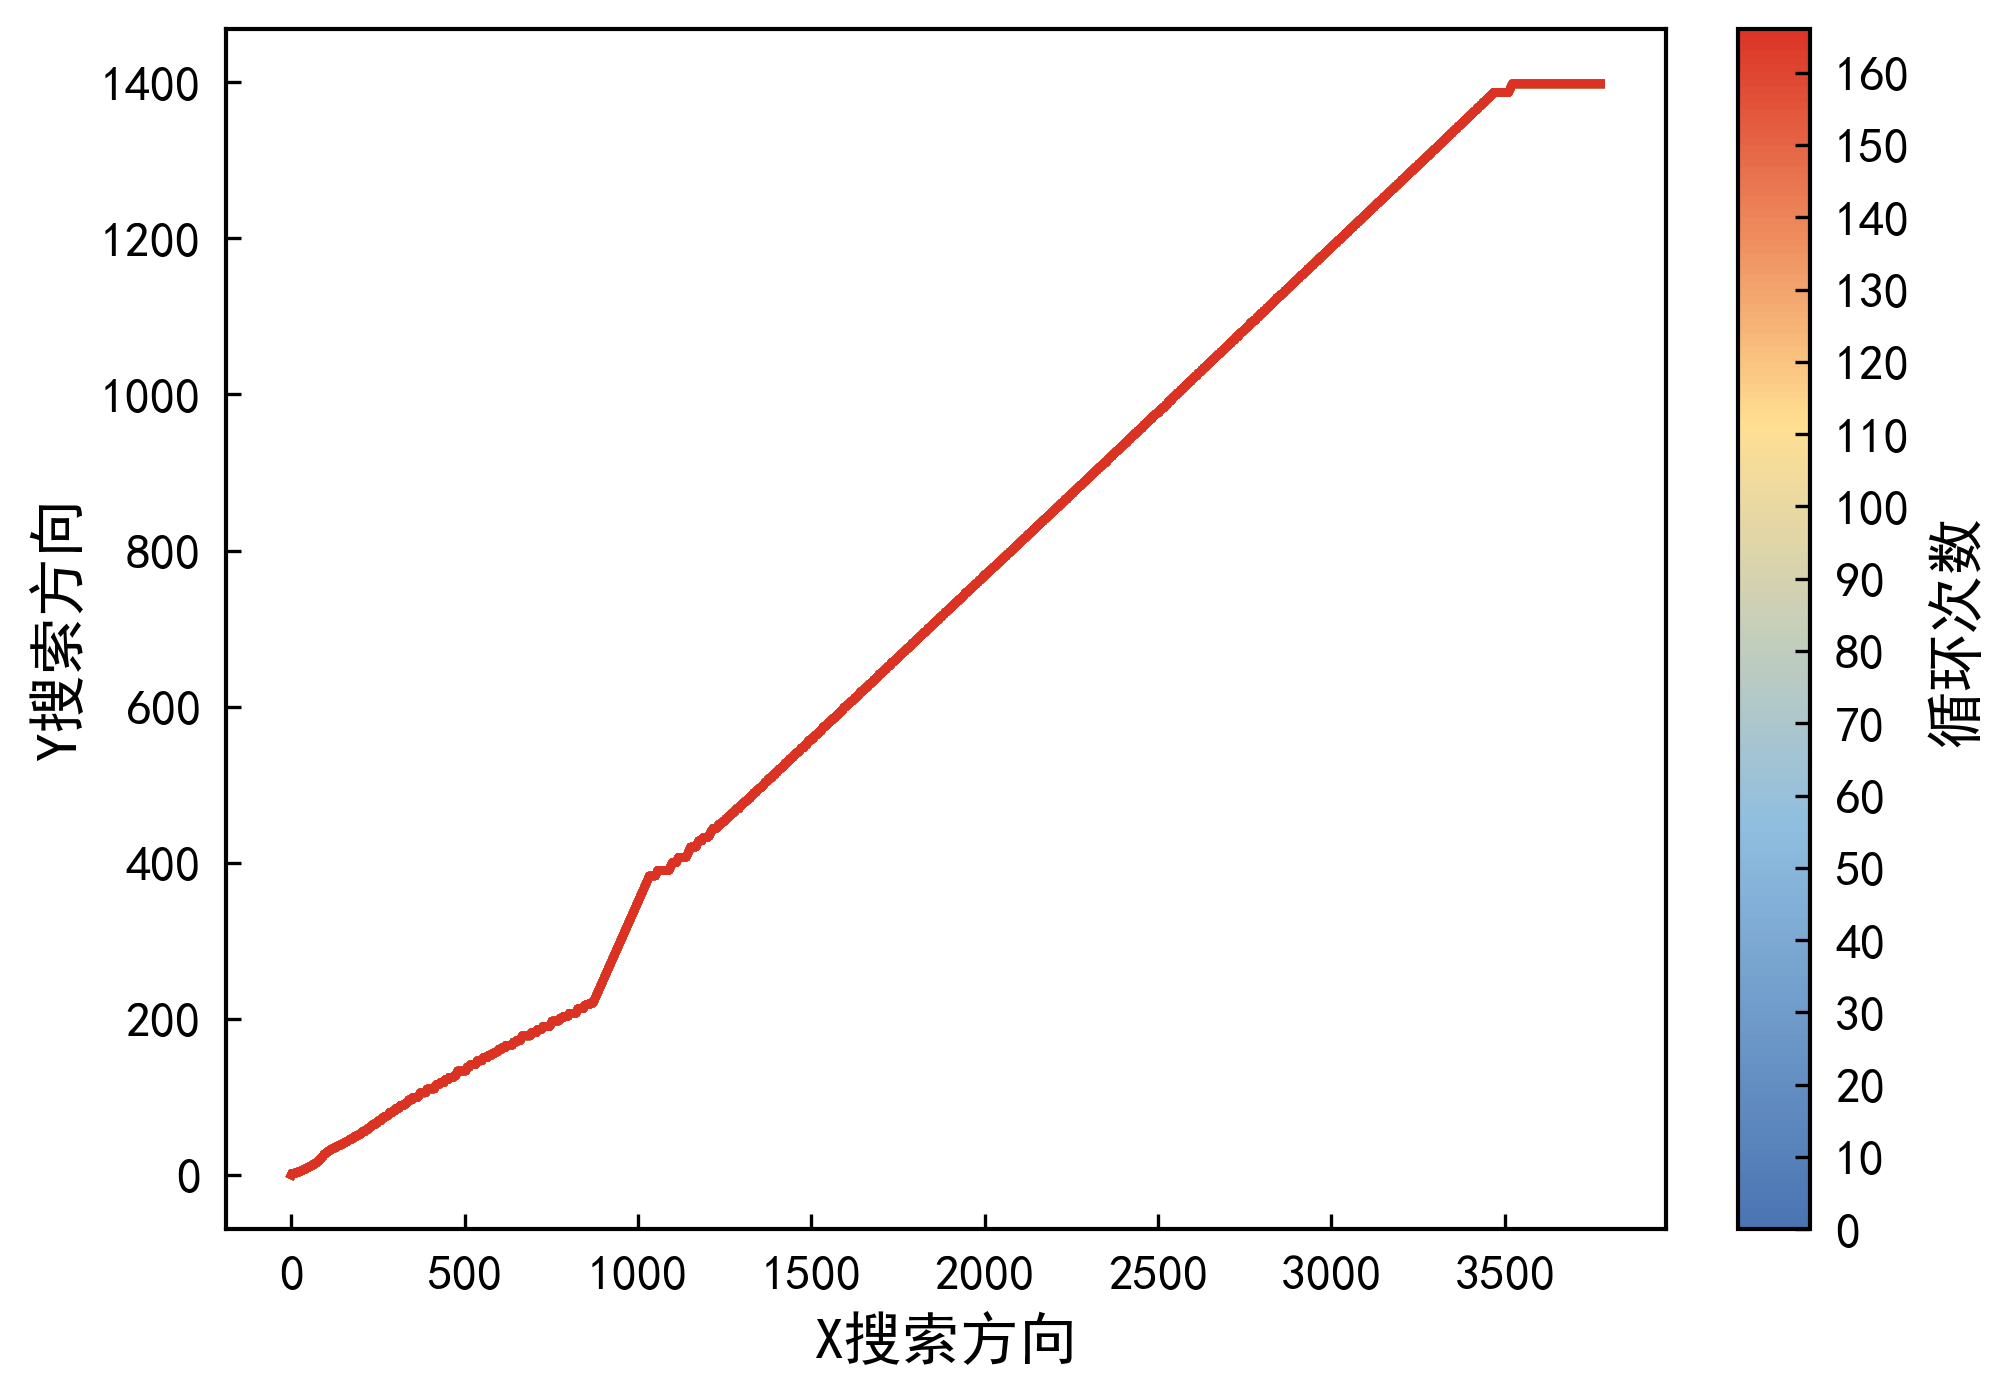

In [296]:
import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw
from fastdtw import fastdtw
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib


Data_list_ = charge['B0005']

scaler = MinMaxScaler()
# 计算并清理模板曲线
# x1, ic_curve1 = get_ic_curve(Data_list_[0])
# clean_ic_curve1 = ic_curve1[~np.isnan(ic_curve1)]

x1, ic_curve1 = get_ic_curve(Data_list_,1)
clean_ic_curve1 = ic_curve1[~np.isnan(ic_curve1)]
# normalized_ic_curve1 = min_max_normalize(clean_ic_curve1, data_min, data_max)

fig = SetFig(column=1)

# 定义颜色

cycles = len(Data_list_)


# 创建一个自定义的颜色映射对象
cmap = fig.create_cmap(cycles)

for i in range(2, cycles):
    xi, ic_curvei = get_ic_curve(Data_list_,i)
    clean_ic_curvei = ic_curvei[~np.isnan(ic_curvei)]
    
    # 计算最优路径
    distance, paths = fastdtw(clean_ic_curve1, clean_ic_curvei)
    path_x, path_y = zip(*path)

    
    # 绘制最优路径
    plt.plot(path_x, path_y,color=cmap(i/cycles), linewidth=2, alpha=0.75)

# 绘制对角线（模板曲线自比）
# plt.plot(range(max(len(clean_ic_curve1), len(xi))), range(max(len(clean_ic_curve1), len(xi))), label='Diagonal (Template)', color='blue', linestyle='--', linewidth=2)

# 设置图例和其他属性
# plt.title('Cell1 IC_V曲线最优规整路径',y=-0.1)
plt.xlabel('X搜索方向')
plt.ylabel('Y搜索方向')
# plt.xlim(0,110)
# plt.ylim(0,110)
# 创建颜色条
fig.create_colorbar(cmap=cmap,norm=plt.Normalize(vmin=0, vmax=cycles),ticks=np.arange(0, cycles, 10), boundaries=np.arange(0, cycles, 1),label = '循环次数')
# plt.grid(True)
# fig.save('IC_V曲线最优规整路径')
# plt.savefig(r'E:\毕业设计\毕业论文\picture\IC_V曲线最优规整路径.svg', format='svg',bbox_inches='tight')

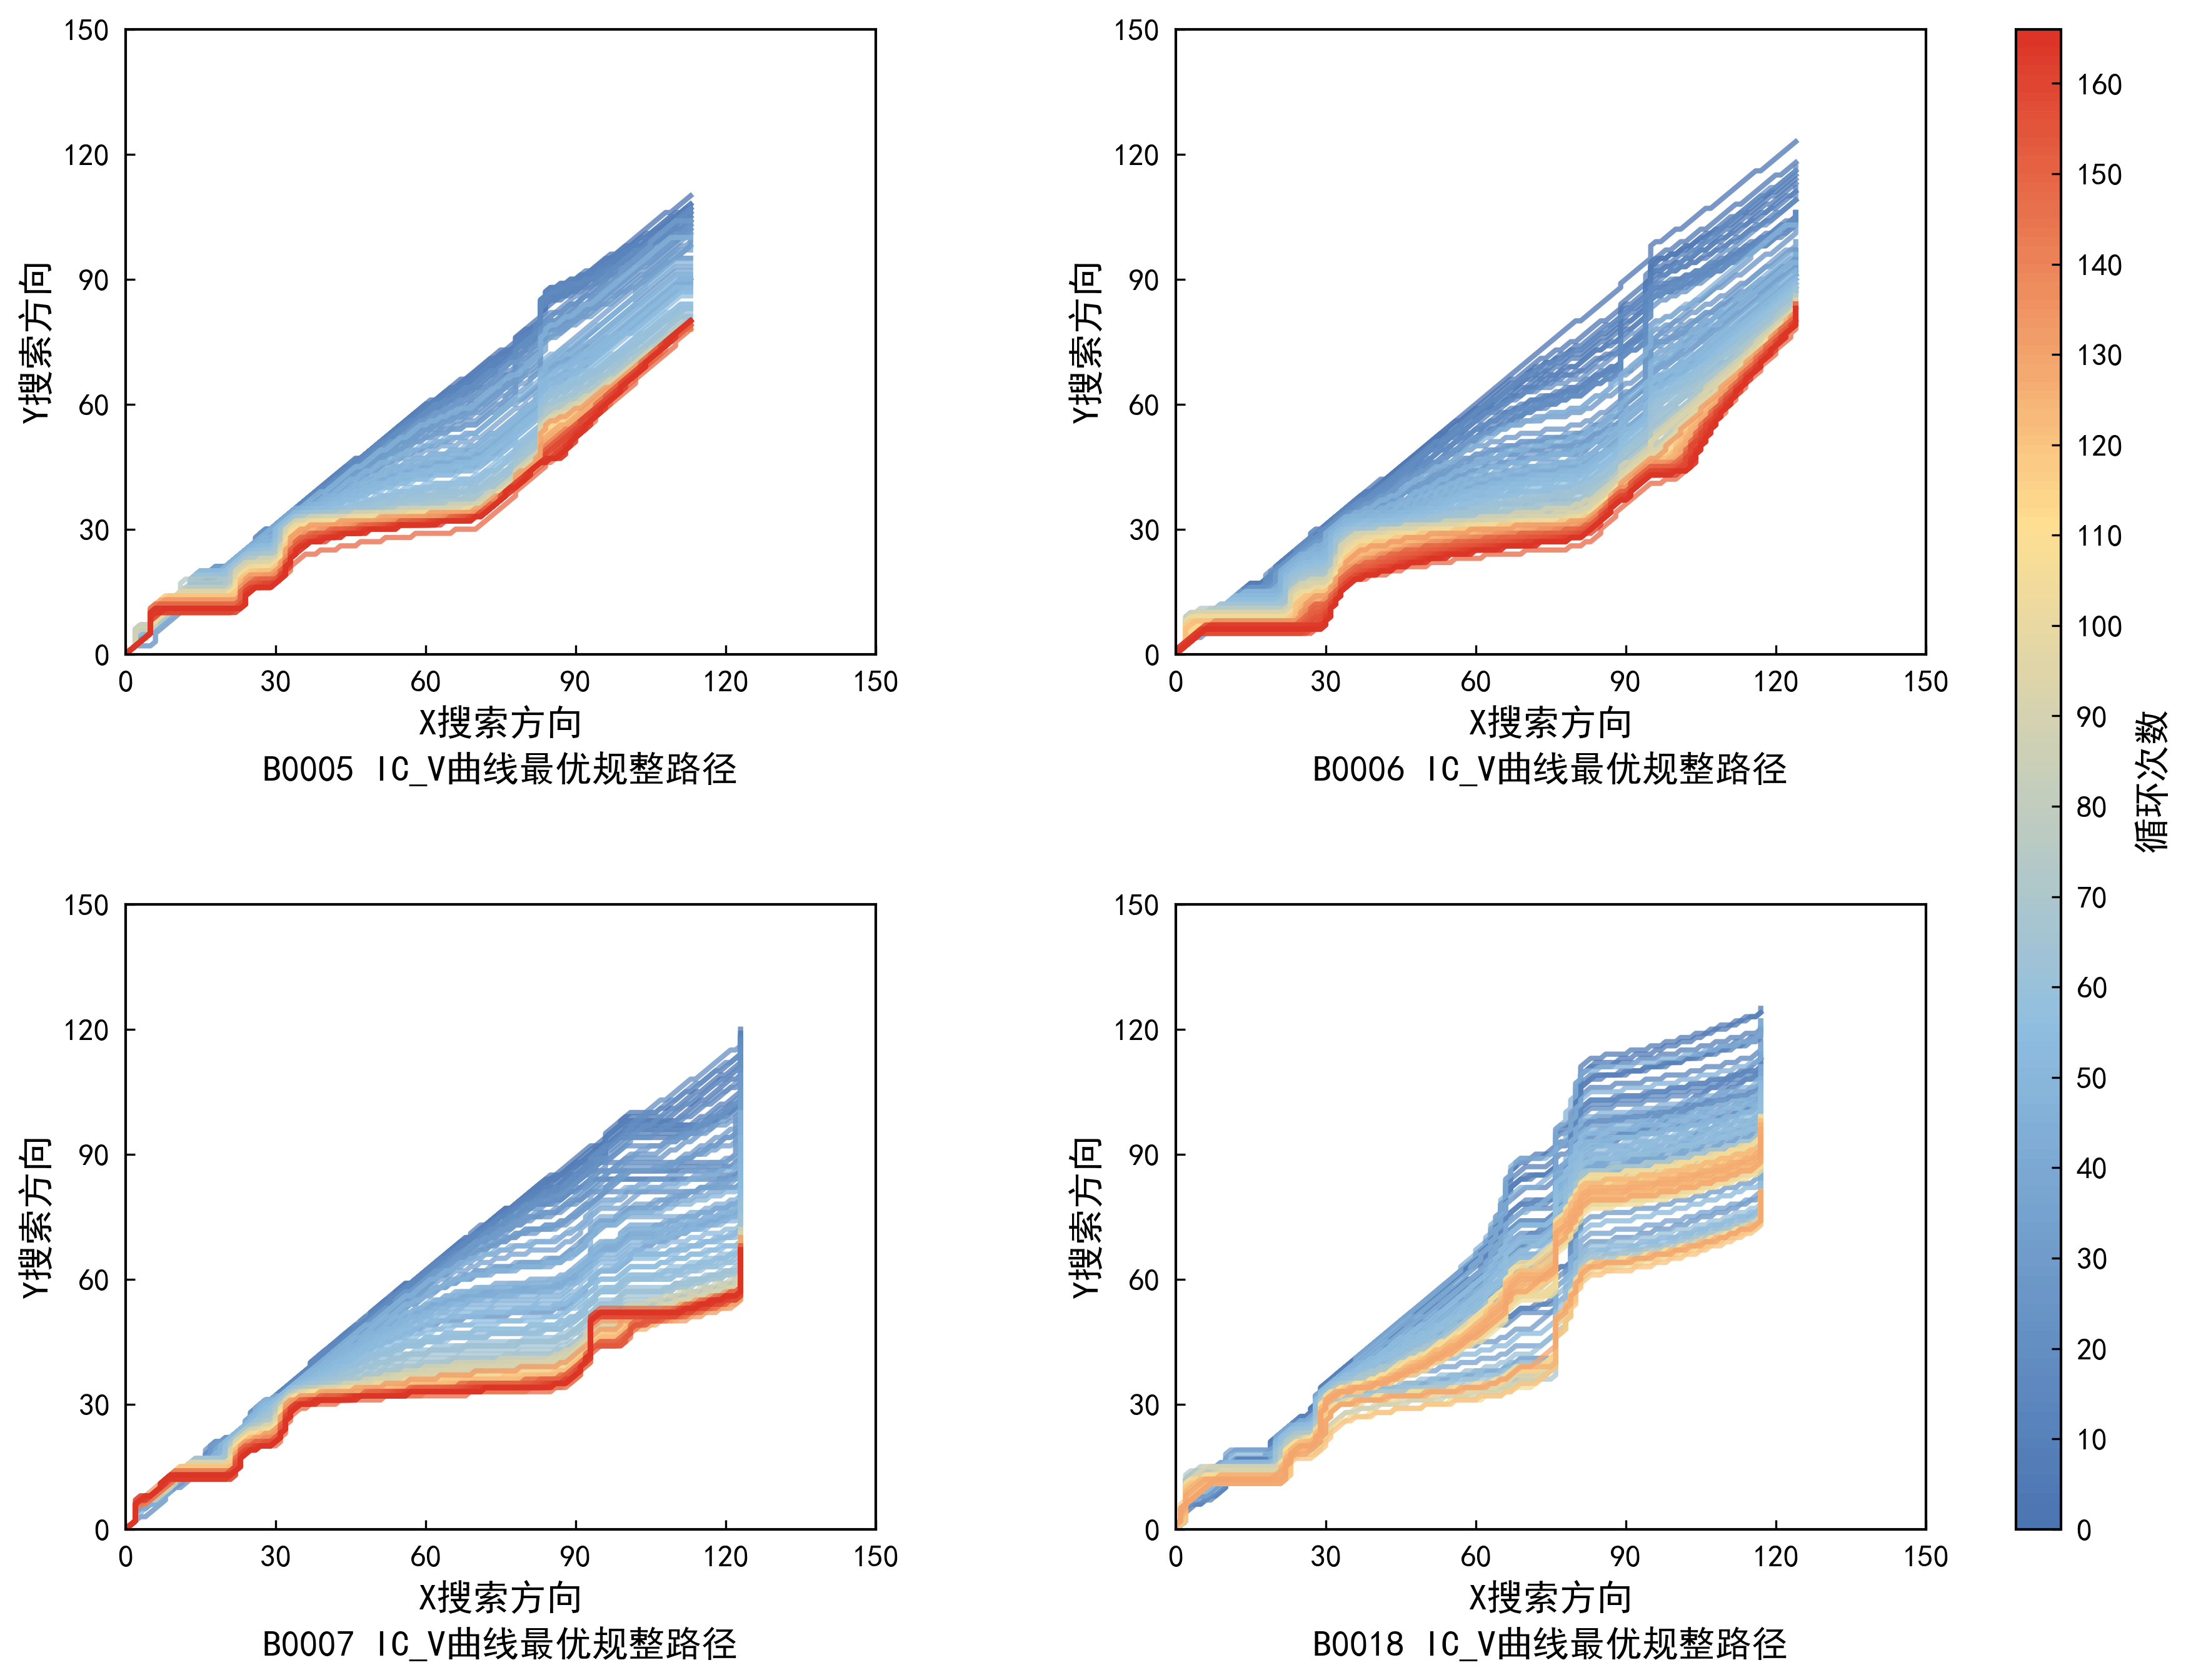

In [299]:
import matplotlib.pyplot as plt
import numpy as np
from dtaidistance import dtw  # 确保已安装此包

# 假设data_list是您的原始数据字典
# data_list = {
#     'Cell1_data': ...,
#     'Cell2_data': ...,
#     'Cell7_data': ...,
#     'Cell8_data': ...
# }

# 创建一个2x2的子图

fig = SetFig(column=4)
# 计算最大循环次数
max_cycles = max(len(charge[cell]) for cell in Battery_list)

cmap= fig.create_cmap(max_cycles-1)
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 可根据需要调整大小
# cells = ['Cell1_data', 'Cell2_data', 'Cell7_data', 'Cell8_data']



for idx, cell in enumerate(Battery_list):
    Data_list_ = charge[cell]
    ax = getattr(fig, f'ax{idx+1}')
    # 计算并清理模板曲线
    x1, ic_curve1 = get_ic_curve(Data_list_,1)
    clean_ic_curve1 = ic_curve1[~np.isnan(ic_curve1)]

#     ax = axs[idx // 2, idx % 2]  # 定位到当前子图
    cycles = len(Data_list_)-1

    # 创建一个自定义的颜色映射对象
    cmap = fig.create_cmap(cycles)

    for i in range(2, cycles):
        xi, ic_curvei = get_ic_curve(Data_list_,i)
        clean_ic_curvei = ic_curvei[~np.isnan(ic_curvei)]

        # 计算最优路径
        distance, paths = dtw.warping_paths(clean_ic_curve1, clean_ic_curvei, window=25, use_pruning=True)
        best_path = dtw.best_path(paths)
        path_x, path_y = zip(*best_path)

        # 绘制最优路径
        ax.plot(path_x, path_y, color=cmap(i/max_cycles), linewidth=2, alpha=0.75)

    # 设置每个子图的轴标签和范围
    ax.set_xlabel('X搜索方向')
    ax.set_ylabel('Y搜索方向')
    ax.set_xlim(0, 130)
    ax.set_ylim(0, 130)
    ax.set_yticks([0,30,60,90,120,150])
    ax.set_xticks([0,30,60,90,120,150])
#     ax.grid()
#     ax.set_title(cell)  # 设置每个子图的标题

fig.ax1.set_title('B0005 IC_V曲线最优规整路径',y=-0.12)
fig.ax2.set_title('B0006 IC_V曲线最优规整路径',y=-0.12)
fig.ax3.set_title('B0007 IC_V曲线最优规整路径',y=-0.12)
fig.ax4.set_title('B0018 IC_V曲线最优规整路径',y=-0.12)
# 创建颜色条
fig.create_colorbar(cmap, norm=plt.Normalize(vmin=0, vmax=max_cycles),ticks=np.arange(0, max_cycles, 10), boundaries=np.arange(0, max_cycles, 1),label = '循环次数')  # 可以调整颜色条的位置和方向

# fig.save('NASA_IC_V曲线最优规整路径-四图')
# plt.savefig(r'E:\毕业设计\毕业论文\picture\IC_V_dtw_curves.svg', format='svg', bbox_inches='tight')

### 建立特征

In [144]:
len(len(charge['B0005'])

SyntaxError: unexpected EOF while parsing (2564836279.py, line 1)

In [52]:
# extract_feature
'''
Voltage_measured,Current_measured,Temperature_measured,Time
'''


def extract(name):
    results_df = pd.DataFrame(columns=[
        'Cyclecount', 'AvgVoltageCharge', 'AvgCurrentCharge',
        'AvgTemperatureCharge', 'VoltageCurrentRatioCharge', 'ICPeakCharge',
        'AvgVoltageDischarge', 'AvgCurrentDischarge',
        'AvgTemperatureDischarge', 'VoltageCurrentRatioDischarge', 'Cap_r', 'SOH'
    ])
    total_Capacity = 0.0
    for i in range(3):  # len(charge[name])
        discharge_data = discharge[name][i]
        total_Capacity += float(discharge_data['Capacity'][0])

    rated_capacity = total_Capacity / 3

    rows_list = []
    for i in range(1,len(charge[name])):  # len(charge[name])
        #     print(str(i))

        #     AvgVoltageCharge, AvgCurrentCharge, AvgTemperatureCharge = [], [], []
        charge_data = charge[name][i]
        AvgVoltageCharge = sum(charge_data['Voltage_measured']) / len(
            charge_data['Voltage_measured'])
        AvgCurrentCharge = sum(charge_data['Current_measured']) / len(
            charge_data['Current_measured'])
        AvgTemperatureCharge = sum(charge_data['Temperature_measured']) / len(
            charge_data['Temperature_measured'])
        VoltageCurrentRatioCharge = AvgVoltageCharge / AvgCurrentCharge
        Cyclecount = int(i)
        discharge_data = discharge[name][i]
        AvgVoltageDischarge = sum(discharge_data['Voltage_measured']) / len(
            discharge_data['Voltage_measured'])
        AvgCurrentDischarge = sum(discharge_data['Current_measured']) / len(
            discharge_data['Current_measured'])
        AvgTemperatureDischarge = sum(
            discharge_data['Temperature_measured']) / len(
                discharge_data['Temperature_measured'])
        VoltageCurrentRatioDischarge = AvgVoltageDischarge / AvgCurrentDischarge
        SOH = discharge_data['Capacity'][0] / rated_capacity
        cap_f = discharge_data['Capacity'][0] 
        Cap_r = 100 - \
            arrhenius_equation(
                (AvgTemperatureCharge+AvgTemperatureDischarge)/2, Cyclecount)  # arniue
        # ic_cruve

        Voltage = np.array(charge_data['Voltage_measured'])
        Current = np.array(charge_data['Current_measured'])
        time = np.array(charge_data['Time'])
        t = np.diff(time)
        ch_cap = np.insert(
            ((Current[:-1] + np.diff(Current) * 0.5) * t / 3600).cumsum(), 0,
            0)
        Data_ = pd.DataFrame({
            'Voltage(V)': Voltage,
            'Current(A)': Current,
            'charge_Capacity(Ah)': ch_cap,
            'Time': time,
        })
        data = Data_
        data.drop_duplicates(subset='Voltage(V)', keep='first',
                             inplace=True)  # 去重
        y = data['charge_Capacity(Ah)'].values
        data = data.sort_values(by='Voltage(V)')  # 电压排序
        x = data['Voltage(V)'].values

        data_x_y = pd.DataFrame({'Voltage': x, 'charge_Capacity(Ah)': y})
        data_x_y = data_x_y[data_x_y['Voltage'] <= 4.15]

        x = data_x_y['Voltage'].values
        y = data_x_y['charge_Capacity(Ah)'].values
        x_new = np.linspace(max(x), min(x), math.ceil(
            (max(x) - min(x)) / 0.01))  # 电压插值

        if len(x) >= 2:
            #         print('icpeak' + str(i))
            f_pchip = interpolate.PchipInterpolator(x, y)  # 生成Pchip插值器
            y = pd.Series(f_pchip(x_new))
            x = pd.Series(x_new)
            dv = x.diff(periods=1)
            dq = y.diff(periods=1)
            ic_cruve = np.array(dq / dv)
             ## 移动平均滤波
            window_size = 3  # 窗口大小，您可以根据需要调整这个值
            maf = pd.Series(f_pchip(x_new)).rolling(window=window_size,min_periods=1).mean().values
            maf = pd.Series(maf)
            maf_dq = maf.diff(periods=1)
            maf_ic_cruve = np.array(maf_dq / dv)
             ## SG滤波
            sg = savgol_filter(f_pchip(x_new), 31, 11,
                               mode='nearest')  # 基于插值器和生成的横坐标，生成电压并滤波
            sg = pd.Series(sg)
            sg_dq = sg.diff(periods=1)
            sg_ic_cruve = np.array(sg_dq / dv)
            
            
            if i % 10 == 0:
                plt.plot(x, sg_dq / dv, label='Cycle' + str(i))
                #           plt.xlim(4.21, 4.19)   #y_a
                #             ax5.set_xlim(3.2, 4.4)  #sg_a
                plt.ylim(0, 6)  # sg_a
                plt.xlabel("Discharge voltage(V)")
                plt.ylabel("Incremental_Capacity(Ah/V)")
                plt.title("IC Curves of Different Cycles")
                plt.grid()
                plt.legend()

            clean_sg_ic_cruve = sg_ic_cruve[~np.isnan(sg_ic_cruve)]
            clean_maf_ic_cruve = maf_ic_cruve[~np.isnan(maf_ic_cruve)]
            clean_ic_cruve = ic_cruve[~np.isnan(ic_cruve)]
            ICPeakCharge = np.max(clean_maf_ic_cruve)
        else:
            #         print('noicpeak' + str(i))
            #         print(data['Voltage(V)'].values)
            #         plt.plot(data['Voltage(V)'].values)
            ICPeakCharge = np.nan
    #     print(ICPeakCharge)
    #     print("------------")
    #     AvgVoltageDischarge、AvgTemperatureDischarge、AvgTemperatureDischarge、AvgCurrentDischarge

#         SOH = "{:.2%}".format(raw_SOH)
        row = pd.DataFrame({
            'Cyclecount': [Cyclecount],
            'AvgVoltageCharge': [AvgVoltageCharge],
            'AvgCurrentCharge': [AvgCurrentCharge],
            'AvgTemperatureCharge': [AvgTemperatureCharge],
            'VoltageCurrentRatioCharge': [VoltageCurrentRatioCharge],
            'ICPeakCharge': [ICPeakCharge],
            #             'AvgVoltageDischarge': [AvgVoltageDischarge],
            #             'AvgCurrentDischarge': [AvgCurrentDischarge],
            #             'AvgTemperatureDischarge': [AvgTemperatureDischarge],
            #             'VoltageCurrentRatioDischarge': [VoltageCurrentRatioDischarge],
            #             'Cap_r':Cap_r,
            'Capacity':[cap_f],
            'SOH': [SOH]
        })
        rows_list.append(row)


#         results_df = pd.concat([results_df, row], ignore_index=True)
    results_df = pd.concat(rows_list, ignore_index=True)
    return results_df
    ##

1.获取IC曲线的测试

Cyclecount  AvgVoltageCharge  AvgCurrentCharge  AvgTemperatureCharge  \
0             1          4.058826          0.949043             26.635623   
1             2          4.058139          0.950529             26.778176   
2             3          4.058905          0.952312             26.703204   
3             4          4.058330          0.947728             26.617004   
4             5          4.059785          0.932661             26.518495   
..          ...               ...               ...                   ...   
161         162          4.180329          0.485142             25.476140   
162         163          4.180892          0.476511             25.506487   
163         164          4.181592          0.463218             25.517453   
164         165          4.180125          0.493932             25.664855   
165         166          4.180702          0.489857             25.433647   

     VoltageCurrentRatioCharge  ICPeakCharge  Capacity       SOH  
0                     4.276759      5.213459  1.846327  1.000148  
1                     4.269349      5.165801  1.835349  0.994201  
2                     4.262161      5.148393  1.835263  0.994154  
3                     4.282165      5.080006  1.834646  0.993820  
4                     4.352907      5.030412  1.835662  0.994370  
..                         ...           ...       ...       ...  
161                   8.616710      2.798926  1.293464  0.700664  
162                   8.773967      2.813198  1.288003  0.697706  
163                   9.027275      2.801552  1.287453  0.697408  
164                   8.462953      2.781514  1.309015  0.709088  
165                   8.534530      3.013897  1.325079  0.717790  

[166 rows x 8 columns]

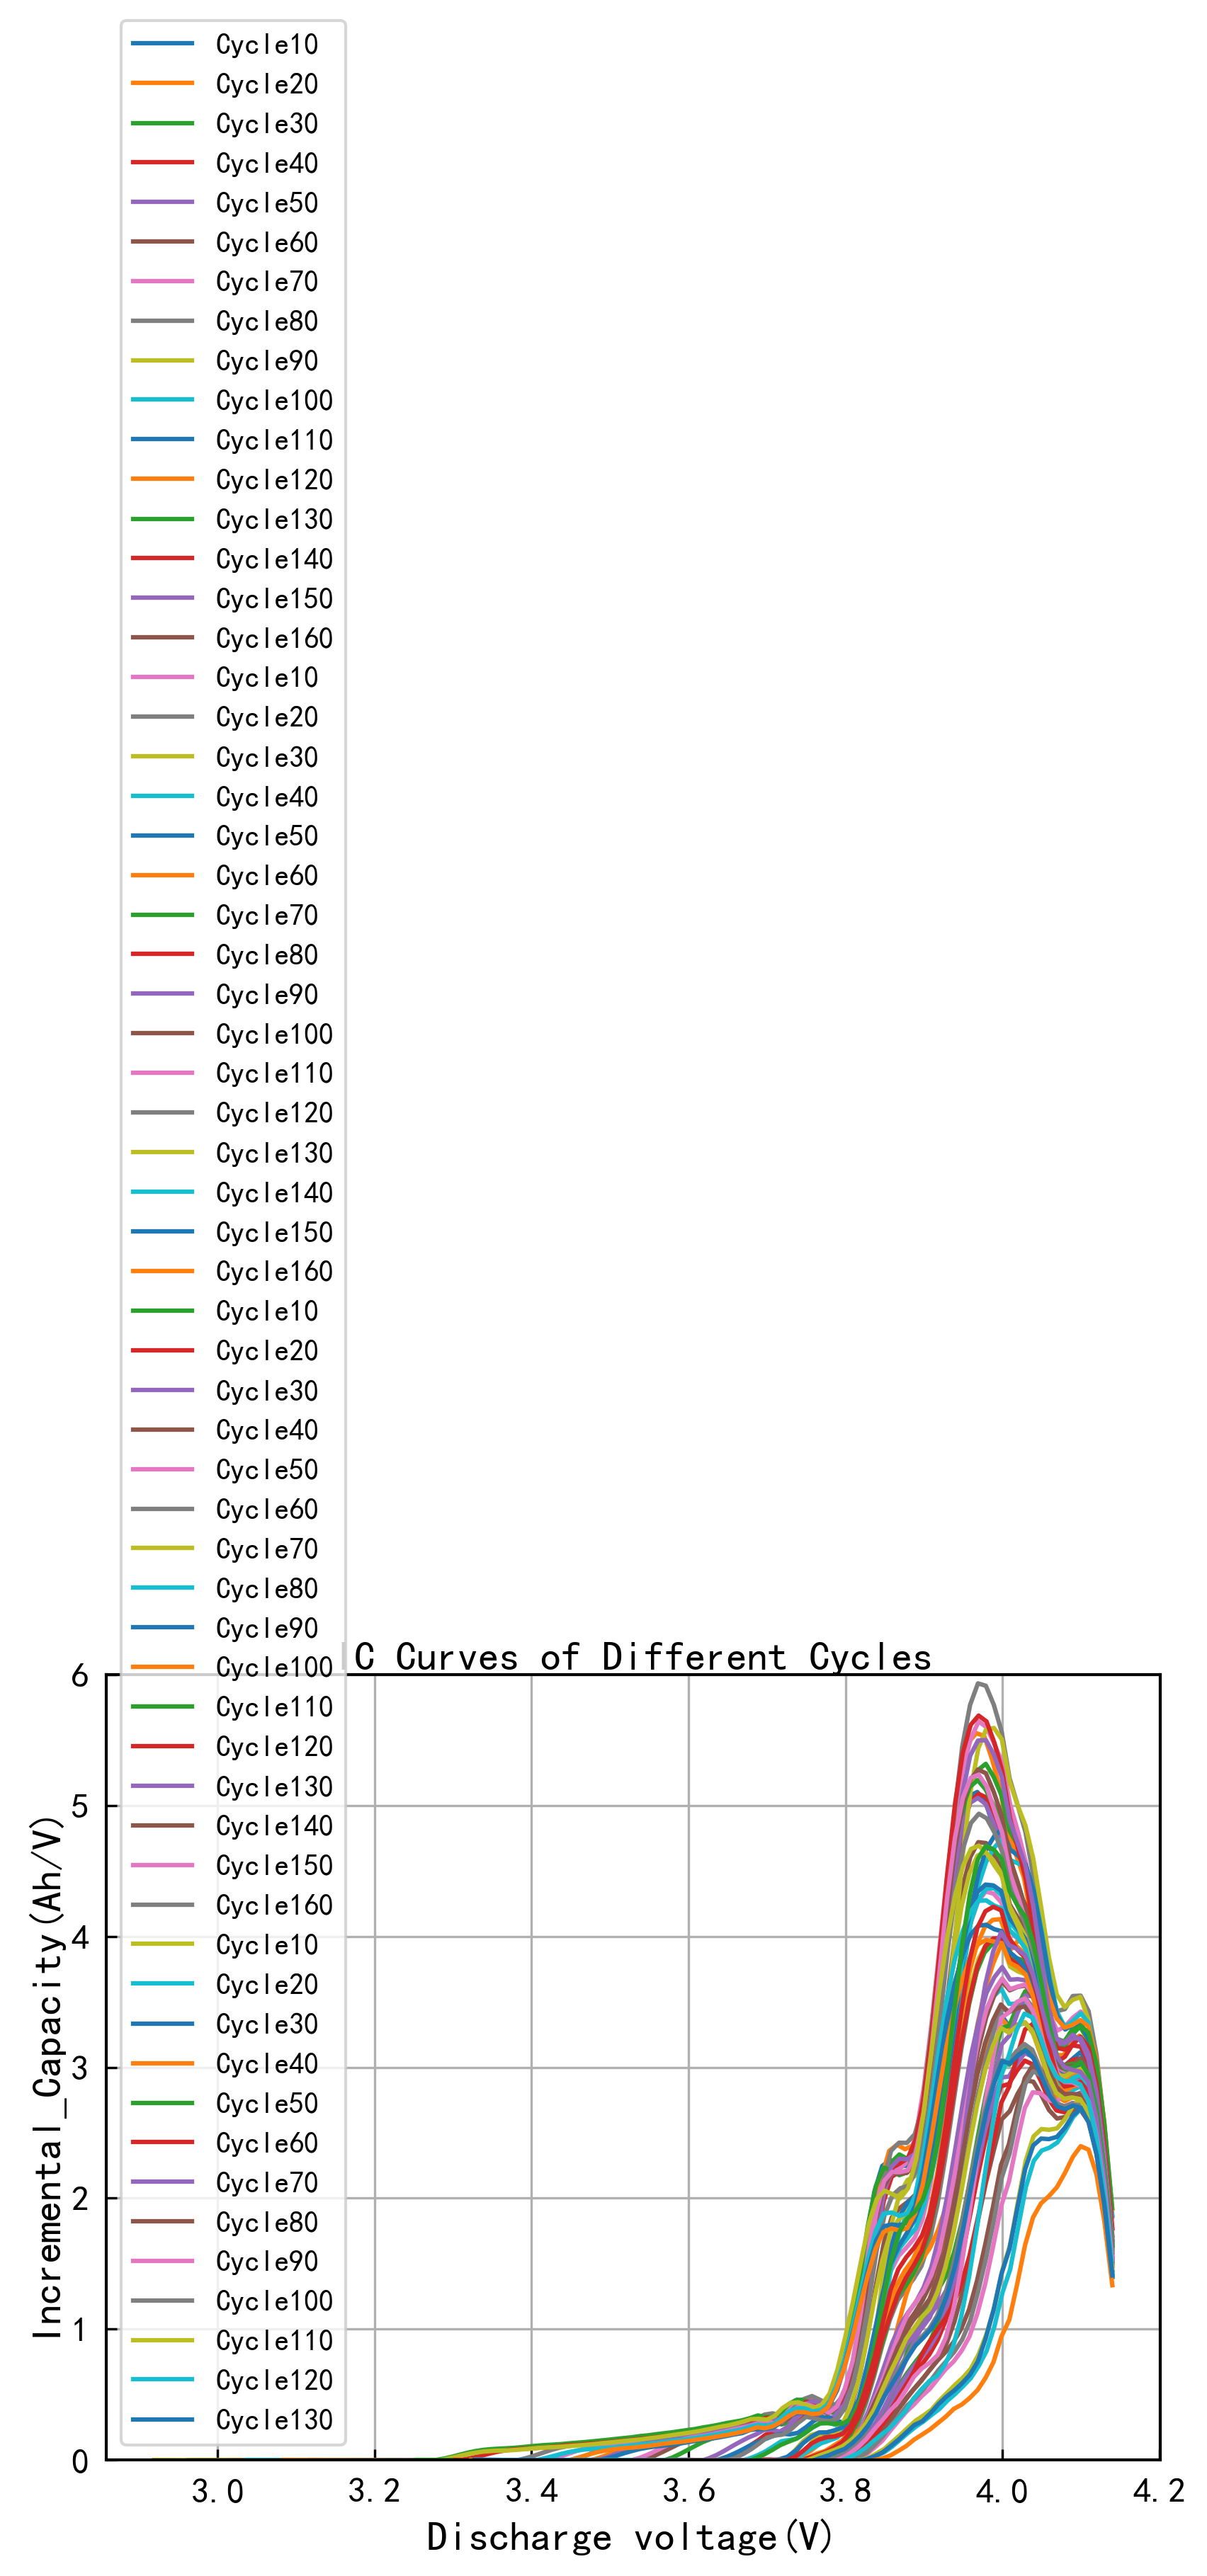

In [53]:
output_path = 'output/'

cell1_df  = extract('B0005')
cell2_df  = extract('B0006')
cell3_df  = extract('B0007')
cell4_df  = extract('B0018')

# train = pd.concat([raw_data1, raw_data2, raw_data3,raw_data4])
# train.to_csv(output_path + 'train.csv', index=False)
cell1_df

In [304]:
cell1_df['dtw_IC']=dtw_ic_lists['B0005']
cell2_df['dtw_IC']=dtw_ic_lists['B0006']
cell3_df['dtw_IC']=dtw_ic_lists['B0007']
cell4_df['dtw_IC']=dtw_ic_lists['B0018']

In [305]:
cell1_df['dtw_Vt']=dtw_vtt_list['B0005']
cell2_df['dtw_Vt']=dtw_vtt_list['B0006']
cell3_df['dtw_Vt']=dtw_vtt_list['B0007']
cell4_df['dtw_Vt']=dtw_vtt_list['B0018']

In [306]:
cell1_df['dv_dt1']=dv_dt1_list['B0005']
cell2_df['dv_dt1']=dv_dt1_list['B0006']
cell3_df['dv_dt1']=dv_dt1_list['B0007']
cell4_df['dv_dt1']=dv_dt1_list['B0018']


In [307]:
cell1_df['dv_dt2']=dv_dt2_list['B0005']
cell2_df['dv_dt2']=dv_dt2_list['B0006']
cell3_df['dv_dt2']=dv_dt2_list['B0007']
cell4_df['dv_dt2']=dv_dt2_list['B0018']


###  输出df

In [312]:
import os

dataframes = [
    cell1_df, cell2_df, cell3_df, cell4_df
]
save_path = "./output/woa_elm_rul/"

for i, df in enumerate(dataframes, start=1):
    save_data = df[[
         'SOH','Capacity','Cyclecount','ICPeakCharge','dtw_IC','dtw_Vt','dv_dt2','dv_dt1'
    ]]
    filename = os.path.join(save_path, f'cell{i}_data.csv')
    save_data.to_csv(filename, index=False)

In [59]:
import pandas as pd
import os

# 定义保存文件的路径
save_path = "./output/woa_elm_rul/"

# 确保输出目录存在，如果不存在则创建
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 读取所有CSV文件
dataframes = []
for i in range(1, 5):  # 假设文件名是按顺序命名的：cell1_data.csv, cell2_data.csv, ...
    filename = os.path.join(save_path, f'cell{i}_data.csv')
    df = pd.read_csv(filename)
    dataframes.append(df)

# 现在dataframes列表包含了所有导入的DataFrame
# 例如，访问第一个DataFrame
print(dataframes[0])

          SOH  Capacity  Cyclecount  ICPeakCharge    dtw_IC     dtw_Vt  \
0    1.000148  1.846327           1      5.213459  0.000000   0.000000   
1    0.994201  1.835349           2      5.165801  0.580605   1.208061   
2    0.994154  1.835263           3      5.148393  0.400727   1.450893   
3    0.993820  1.834646           4      5.080006  0.464278   1.770767   
4    0.994370  1.835662           5      5.030412  0.548685   1.930431   
..        ...       ...         ...           ...       ...        ...   
161  0.700664  1.293464         162      2.798926  5.124180  97.920072   
162  0.697706  1.288003         163      2.813198  5.134653  98.675264   
163  0.697408  1.287453         164      2.801552  5.125984  99.848082   
164  0.709088  1.309015         165      2.781514  5.180095  99.240829   
165  0.717790  1.325079         166      3.013897  4.430518  98.879031   

       dv_dt2   dv_dt1  
0    1547.672  501.094  
1    1518.969  525.719  
2    1503.781  536.437  
3    1495.0

In [60]:
cell1_df = dataframes[0]
cell2_df = dataframes[1]
cell3_df = dataframes[2]
cell4_df = dataframes[3]

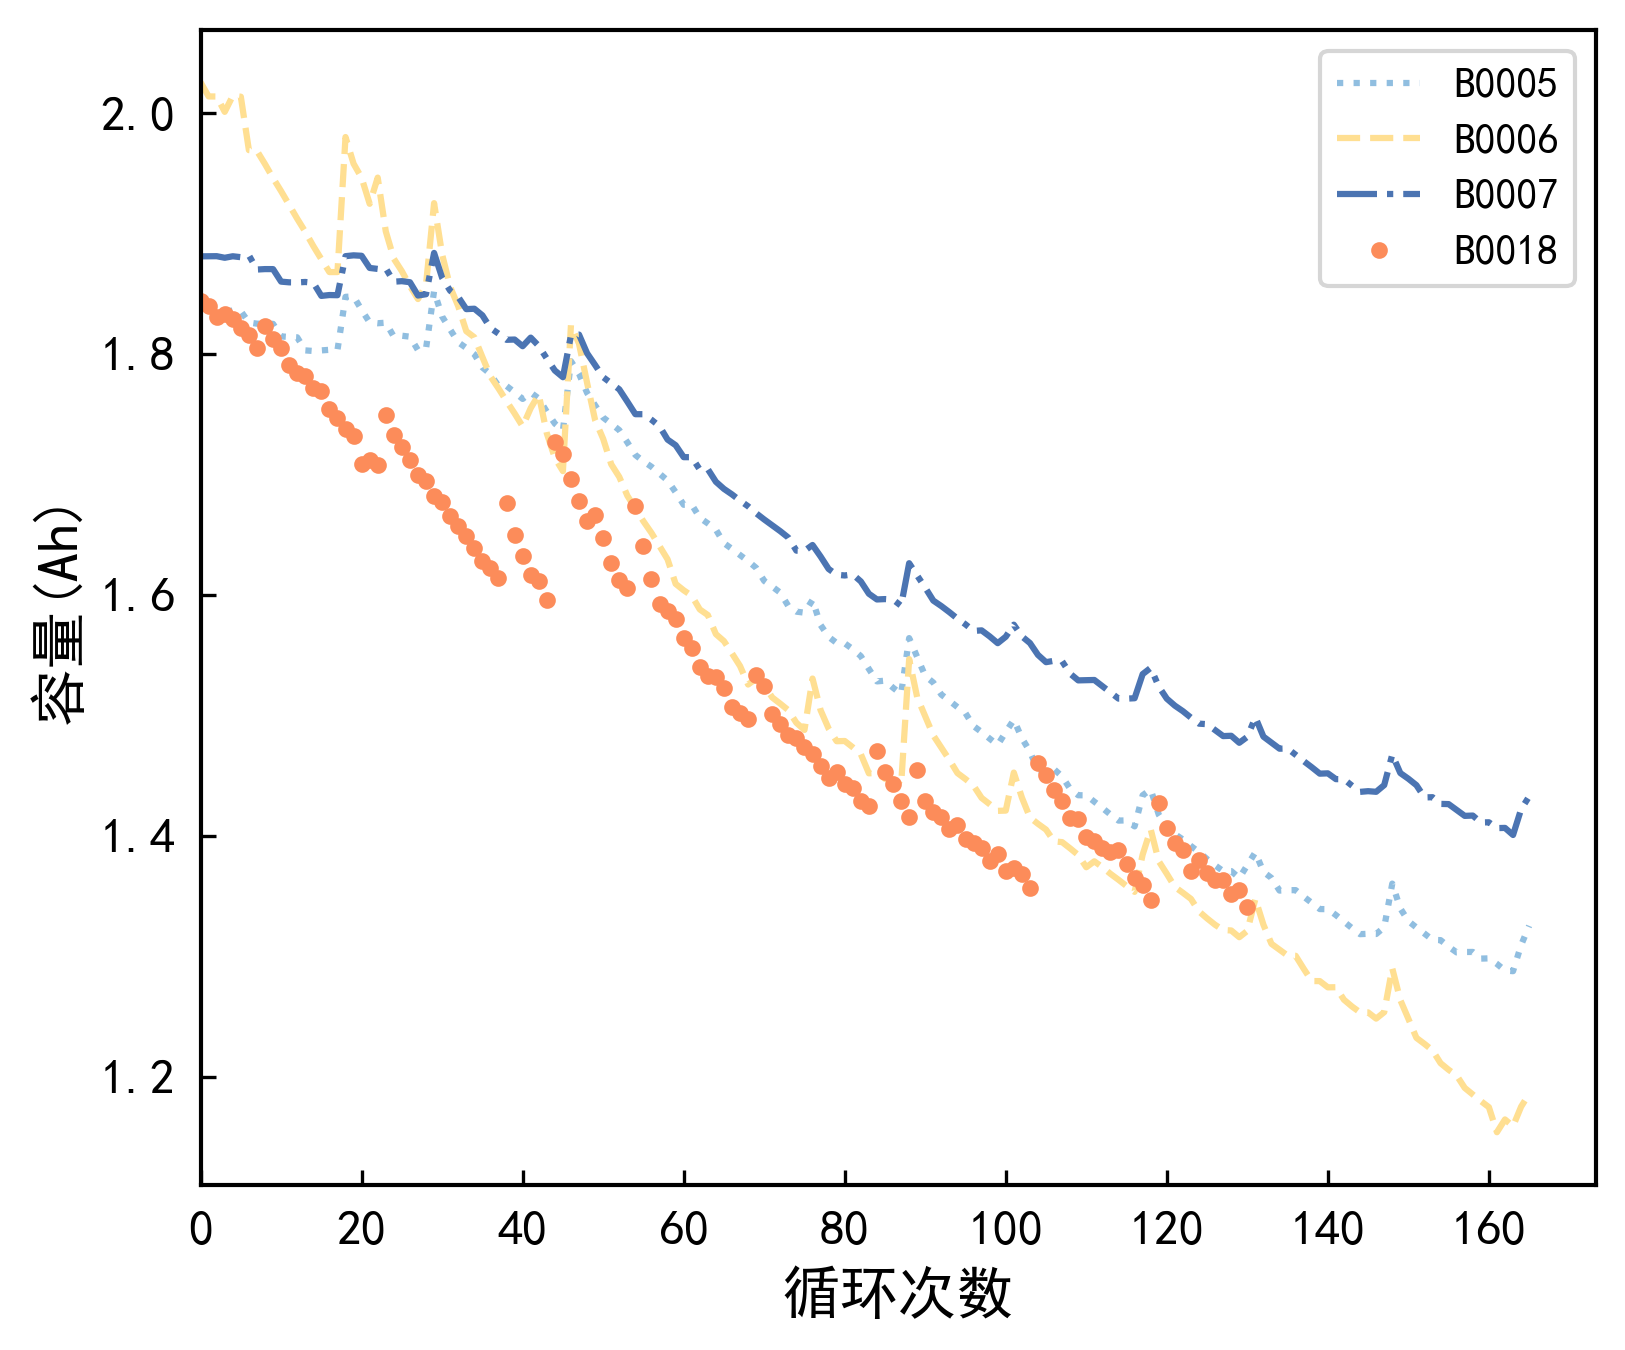

In [39]:

fig = SetFig(column=1,font=0)
color = fig.colors
plt.plot(dataframes[0]['Capacity'],':',color=color[1],label='B0005')
plt.plot(dataframes[1]['Capacity'],'--',color=color[3],label='B0006')
plt.plot(dataframes[2]['Capacity'],'-.',color=color[0],label='B0007')
plt.plot(dataframes[3]['Capacity'],'.',color=color[4],label='B0018')

plt.legend()
plt.ylabel('容量(Ah)')
plt.xlabel('循环次数')
plt.xlim(0,)
fig.save('NASA_CAP')

### 相关性分析

In [271]:
cell4_df.columns

Index(['Cyclecount', 'AvgVoltageCharge', 'AvgCurrentCharge',
       'AvgTemperatureCharge', 'VoltageCurrentRatioCharge', 'ICPeakCharge',
       'SOH', 'dtw_IC', 'dv_dt1', 'dv_dt2', 'dtw_Vt'],
      dtype='object')

In [89]:
## 相关性分析
df = cell1_df[[ 'SOH','ICPeakCharge','dv_dt2','dv_dt1','dtw_IC','dtw_Vt',
       ]]
pearson_corr = df.corr(method='kendall')#kendall、spearman、pearson
print("Pearson相关系数:")
print(pearson_corr)

Pearson相关系数:
                   SOH  ICPeakCharge    dv_dt2    dv_dt1    dtw_IC    dtw_Vt
SOH           1.000000      0.931070  0.916280  0.891785 -0.938810 -0.930924
ICPeakCharge  0.931070      1.000000  0.947972  0.872508 -0.944067 -0.892662
dv_dt2        0.916280      0.947972  1.000000  0.858885 -0.913067 -0.881668
dv_dt1        0.891785      0.872508  0.858885  1.000000 -0.882585 -0.921139
dtw_IC       -0.938810     -0.944067 -0.913067 -0.882585  1.000000  0.914129
dtw_Vt       -0.930924     -0.892662 -0.881668 -0.921139  0.914129  1.000000


In [90]:
## 相关性分析
df = cell2_df[['SOH','ICPeakCharge','dv_dt2','dv_dt1','dtw_IC','dtw_Vt'
       ]]
# df = cell2_df[[ 'SOH','AvgVoltageCharge'
#        ]]
pearson_corr = df.corr(method='kendall')#kendall、spearman、pearson
print("Pearson相关系数:")
print(pearson_corr)

Pearson相关系数:
                   SOH  ICPeakCharge    dv_dt2    dv_dt1    dtw_IC    dtw_Vt
SOH           1.000000      0.964221  0.945966  0.934974 -0.965681 -0.936911
ICPeakCharge  0.964221      1.000000  0.964221  0.927234 -0.987441 -0.930047
dv_dt2        0.945966      0.964221  1.000000  0.928256 -0.962176 -0.929025
dv_dt1        0.934974      0.927234  0.928256  1.000000 -0.930447 -0.956734
dtw_IC       -0.965681     -0.987441 -0.962176 -0.930447  1.000000  0.929755
dtw_Vt       -0.936911     -0.930047 -0.929025 -0.956734  0.929755  1.000000


In [91]:
## 相关性分析
df = cell3_df[['SOH','ICPeakCharge','dv_dt2','dv_dt1','dtw_IC','dtw_Vt'
       ]]
# df = cell3_df[[ 'SOH','AvgVoltageCharge'
#        ]]
pearson_corr = df.corr(method='kendall')#kendall、spearman、pearson
print("Pearson相关系数:")
print(pearson_corr)

Pearson相关系数:
                   SOH  ICPeakCharge    dv_dt2    dv_dt1    dtw_IC    dtw_Vt
SOH           1.000000      0.916028  0.911062  0.879290 -0.912961 -0.934429
ICPeakCharge  0.916028      1.000000  0.957357  0.858551 -0.945528 -0.891347
dv_dt2        0.911062      0.957357  1.000000  0.840441 -0.928587 -0.889011
dv_dt1        0.879290      0.858551  0.840441  1.000000 -0.863809 -0.891850
dtw_IC       -0.912961     -0.945528 -0.928587 -0.863809  1.000000  0.900548
dtw_Vt       -0.934429     -0.891347 -0.889011 -0.891850  0.900548  1.000000


In [92]:
## 相关性分析
df = cell4_df[['SOH','ICPeakCharge','dv_dt2','dv_dt1','dtw_IC','dtw_Vt'
       ]]
# df = cell4_df[[ 'SOH','AvgVoltageCharge'
#        ]]
pearson_corr = df.corr(method='kendall')#kendall、spearman、pearson
print("Pearson相关系数:")
print(pearson_corr)

Pearson相关系数:
                   SOH  ICPeakCharge    dv_dt2    dv_dt1    dtw_IC    dtw_Vt
SOH           1.000000      0.857428  0.872695  0.784309 -0.852026 -0.739284
ICPeakCharge  0.857428      1.000000  0.943864  0.686828 -0.980975 -0.650734
dv_dt2        0.872695      0.943864  1.000000  0.704915 -0.948326 -0.672108
dv_dt1        0.784309      0.686828  0.704915  1.000000 -0.679312 -0.792765
dtw_IC       -0.852026     -0.980975 -0.948326 -0.679312  1.000000  0.644392
dtw_Vt       -0.739284     -0.650734 -0.672108 -0.792765  0.644392  1.000000


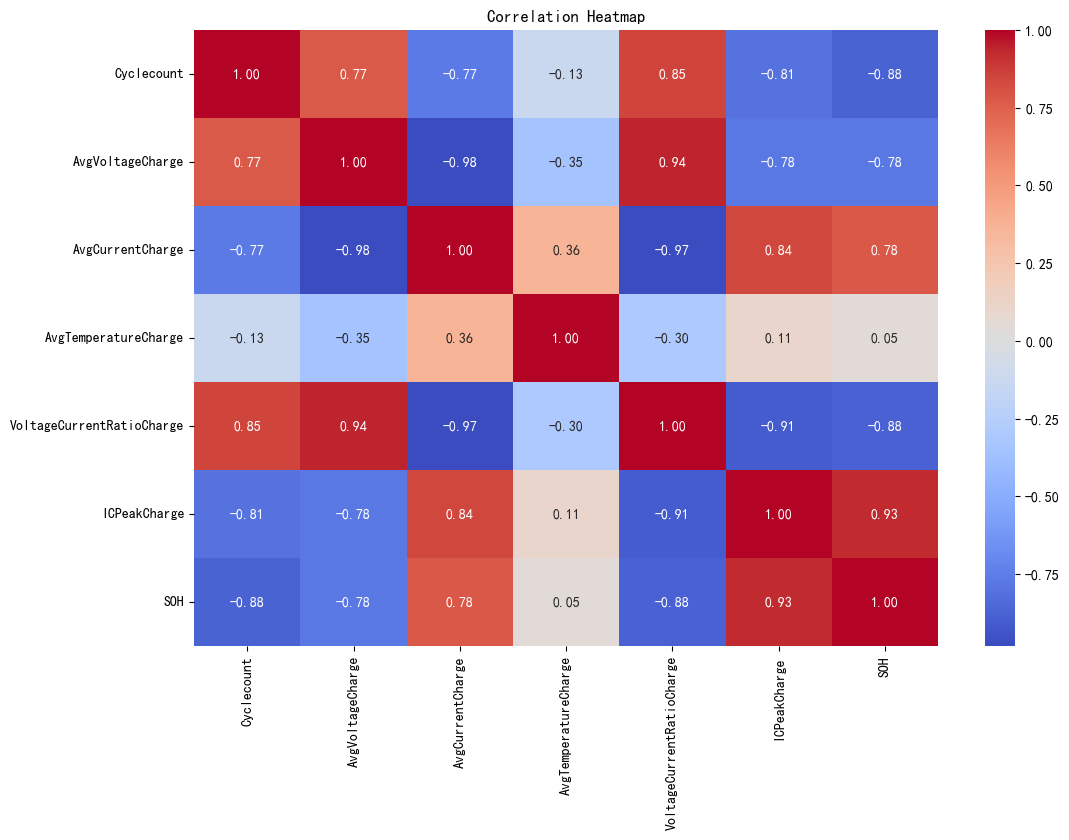

In [20]:
import seaborn as sns

# 计算特征与标签之间的相关性（假设 SOH 列是标签列）
# correlation_matrix = df.corr(method='spearman')
sns_df = pd.concat([raw_data3, raw_data2, raw_data4], ignore_index=True)
correlation_matrix = sns_df.corr(method='pearson')

# 使用热力图可视化相关性矩阵
plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### VIF

In [301]:
## VIF分析
# 导入必要的库
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 假设df是你的DataFrame，里面包含了你的特征变量
# 例如:
df = cell1_df[['ICPeakCharge','dtw_IC', 'dtw_Vt','dv_dt1', 'dv_dt2'
       ]]

# 为数据集添加常数项，用于计算截距项的VIF
df_with_constant = add_constant(df)

# 初始化一个空列表，用来存储每个变量的VIF值
vif = []

# 对每一个列（变量）计算VIF值，并添加到列表
for i in range(len(df_with_constant.columns)):
    vif.append(variance_inflation_factor(df_with_constant.values, i))

# 将VIF值和变量名整合到一个DataFrame中便于查看
vif_df = pd.DataFrame({'Variable': df_with_constant.columns, 'VIF': vif})

# 显示VIF值
print(vif_df)

       Variable          VIF
0         const  5613.629671
1  ICPeakCharge   143.265991
2        dtw_IC   107.282941
3        dtw_Vt    94.849747
4        dv_dt1    97.312525
5        dv_dt2   123.787528


In [334]:
## VIF分析
# 导入必要的库
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 假设df是你的DataFrame，里面包含了你的特征变量
# 例如:
df = cell2_df[['ICPeakCharge','dtw_IC', 'dtw_Vt','dv_dt1', 'dv_dt2'
       ]]

# 为数据集添加常数项，用于计算截距项的VIF
df_with_constant = add_constant(df)

# 初始化一个空列表，用来存储每个变量的VIF值
vif = []

# 对每一个列（变量）计算VIF值，并添加到列表
for i in range(len(df_with_constant.columns)):
    vif.append(variance_inflation_factor(df_with_constant.values, i))

# 将VIF值和变量名整合到一个DataFrame中便于查看
vif_df = pd.DataFrame({'Variable': df_with_constant.columns, 'VIF': vif})

# 显示VIF值
print(vif_df)

       Variable          VIF
0         const  5352.231139
1  ICPeakCharge   113.982937
2        dtw_IC   174.747045
3        dtw_Vt   166.128684
4        dv_dt1   149.497157
5        dv_dt2   195.614844


In [335]:
## VIF分析
# 导入必要的库
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 假设df是你的DataFrame，里面包含了你的特征变量
# 例如:
df = cell3_df[['ICPeakCharge','dtw_IC', 'dtw_Vt','dv_dt1', 'dv_dt2'
       ]]

# 为数据集添加常数项，用于计算截距项的VIF
df_with_constant = add_constant(df)

# 初始化一个空列表，用来存储每个变量的VIF值
vif = []

# 对每一个列（变量）计算VIF值，并添加到列表
for i in range(len(df_with_constant.columns)):
    vif.append(variance_inflation_factor(df_with_constant.values, i))

# 将VIF值和变量名整合到一个DataFrame中便于查看
vif_df = pd.DataFrame({'Variable': df_with_constant.columns, 'VIF': vif})

# 显示VIF值
print(vif_df)

       Variable          VIF
0         const  9260.926693
1  ICPeakCharge   154.658534
2        dtw_IC    87.816265
3        dtw_Vt    64.139057
4        dv_dt1    51.474777
5        dv_dt2    92.840436


In [342]:
## VIF分析
# 导入必要的库
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 假设df是你的DataFrame，里面包含了你的特征变量
# 例如:
df = cell4_df[['ICPeakCharge','dtw_IC', 'dv_dt1'
       ]]

# 为数据集添加常数项，用于计算截距项的VIF
df_with_constant = add_constant(df)

# 初始化一个空列表，用来存储每个变量的VIF值
vif = []

# 对每一个列（变量）计算VIF值，并添加到列表
for i in range(len(df_with_constant.columns)):
    vif.append(variance_inflation_factor(df_with_constant.values, i))

# 将VIF值和变量名整合到一个DataFrame中便于查看
vif_df = pd.DataFrame({'Variable': df_with_constant.columns, 'VIF': vif})

# 显示VIF值
print(vif_df)

       Variable          VIF
0         const  8832.700933
1  ICPeakCharge   173.067295
2        dtw_IC   161.169813
3        dv_dt1     2.950225


### PCA

In [62]:
## PCA分析
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 假设df是你的DataFrame
# df = pd.read_csv('your_dataset.csv')
dataframes = [cell1_df, cell2_df,cell3_df,cell4_df]
for df in dataframes:
    # 选择特征变量，这里假设所有列都是特征
    X = df[['ICPeakCharge','dtw_IC','dtw_Vt','dv_dt2','dv_dt1']]

    # 标准化特征变量
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 初始化PCA模型，选择主成分个数
    pca = PCA(n_components=3)

    # 拟合PCA模型
    X_pca = pca.fit_transform(X_scaled)
#     print("str{dataframes})
    # 查看主成分解释的方差比例
    print("解释的方差比例: ", pca.explained_variance_ratio_)
    
    # 将PCA结果转换为DataFrame，便于进一步分析
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'])
    pca_df['SOH'] = df['SOH'].values
    pearson_corr = pca_df.corr(method='pearson')#kendall、spearman、pearson
    print("Pearson相关系数:")
    print(pearson_corr)
    pearson_corr = pca_df.corr(method='spearman')#kendall、spearman、pearson
    print("spearman相关系数:")
    print(pearson_corr)
    pearson_corr = pca_df.corr(method='kendall')#kendall、spearman、pearson
    print("kendall相关系数:")
    print(pearson_corr)
    # 查看PCA结果
    print(pca_df.head())

解释的方差比例:  [0.98521217 0.0106823  0.00223582]
Pearson相关系数:
              PC1           PC2           PC3       SOH
PC1  1.000000e+00  2.047893e-16 -2.508021e-16 -0.998128
PC2  2.047893e-16  1.000000e+00  2.060263e-16 -0.018869
PC3 -2.508021e-16  2.060263e-16  1.000000e+00  0.015544
SOH -9.981275e-01 -1.886872e-02  1.554413e-02  1.000000
spearman相关系数:
          PC1       PC2       PC3       SOH
PC1  1.000000 -0.053000  0.144375 -0.994887
PC2 -0.053000  1.000000 -0.191180  0.052184
PC3  0.144375 -0.191180  1.000000 -0.161766
SOH -0.994887  0.052184 -0.161766  1.000000
kendall相关系数:
          PC1       PC2       PC3       SOH
PC1  1.000000 -0.111208  0.206718 -0.954436
PC2 -0.111208  1.000000 -0.188901  0.101278
PC3  0.206718 -0.188901  1.000000 -0.209931
SOH -0.954436  0.101278 -0.209931  1.000000
        PC1       PC2       PC3       SOH
0 -2.998887  0.035312  0.252927  1.000148
1 -2.814501 -0.195921  0.226649  0.994201
2 -2.850849 -0.210603  0.129088  0.994154
3 -2.802264 -0.263545  0.05

C:\Users\PC\AppData\Local\Temp\ipykernel_24940\2368017892.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.savefig(filepath, format='svg',bbox_inches='tight', pad_inches=pad_inches)
D:\Anaconda\envs\soc_ml\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
D:\Anaconda\envs\soc_ml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


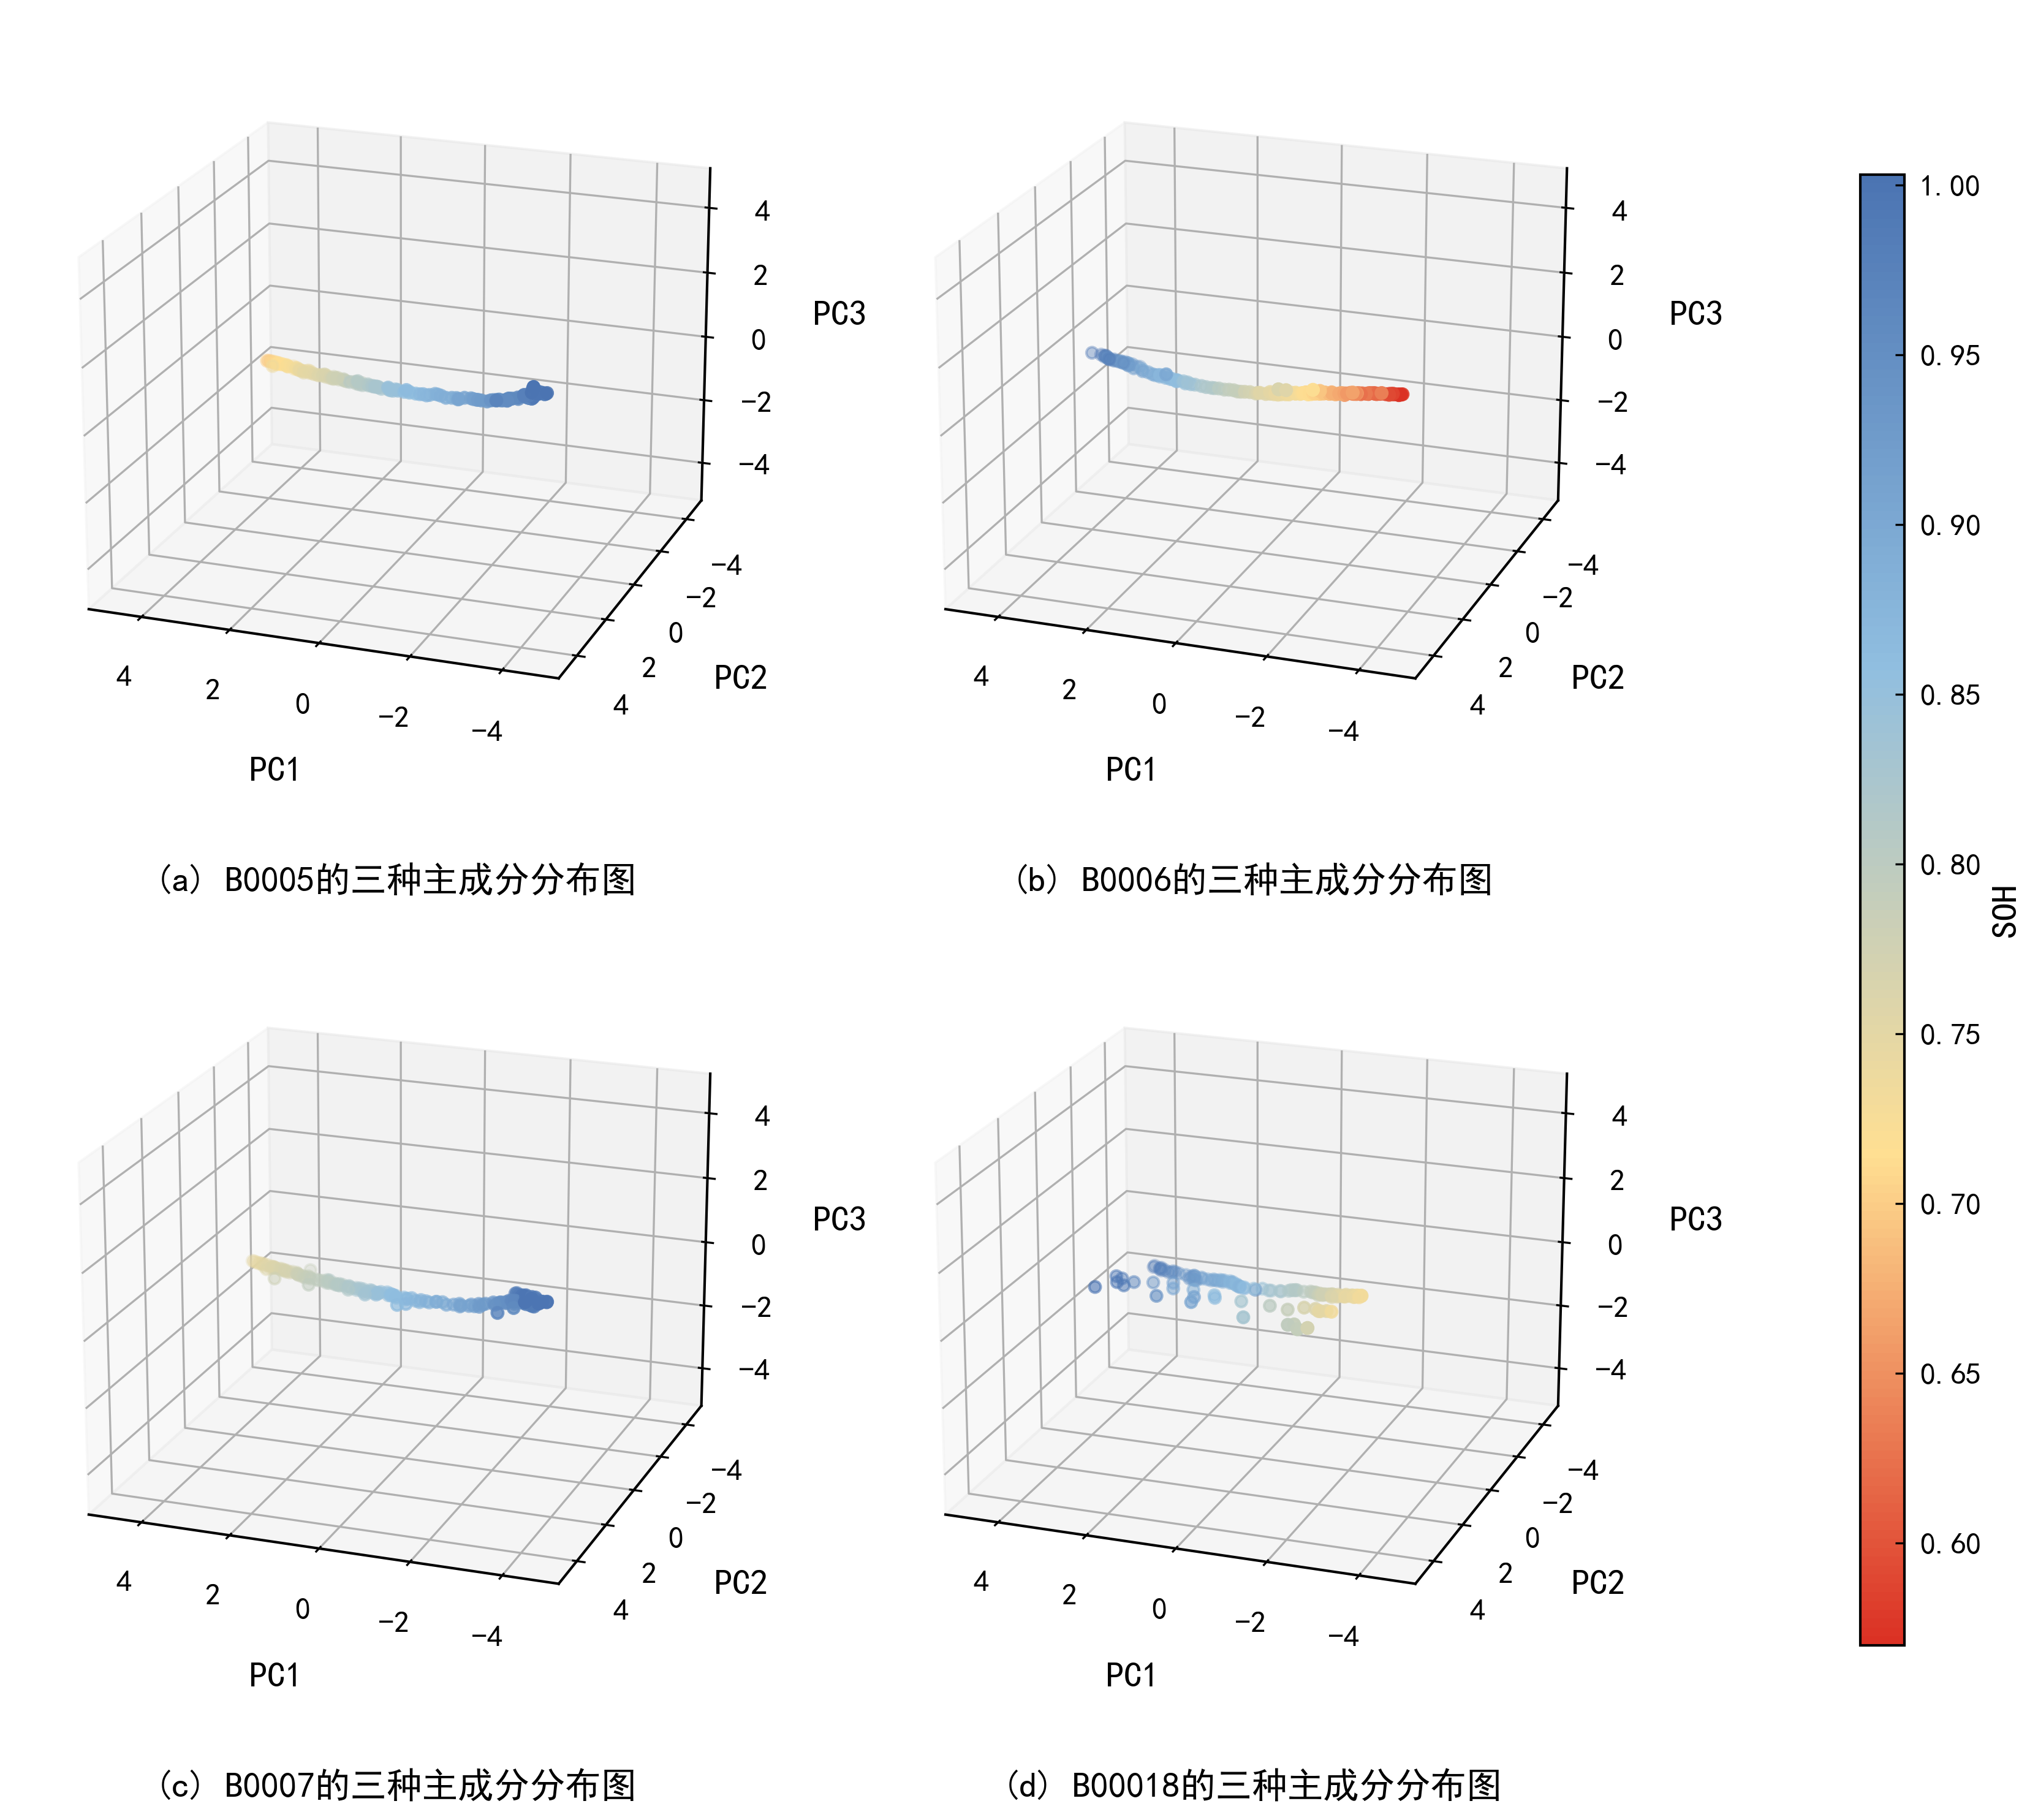

In [86]:
dataframes = [cell1_df, cell2_df, cell3_df, cell4_df]
titles = [
    "(a) B0005的三种主成分分布图", "(b) B0006的三种主成分分布图", "(c) B0007的三种主成分分布图", "(d) B00018的三种主成分分布图"
]

# 首先，确定全局SOH的最小值和最大值

global_soh_min = min(df['SOH'].min() for df in dataframes)
global_soh_max = max(df['SOH'].max() for df in dataframes)
# 创建归一化对象
norm = Normalize(vmin=global_soh_min, vmax=global_soh_max)

fig = SetFig(column=4_3)
colors_rgb = (np.array([
    [75, 116, 178],
    [144, 190, 224],
    [255, 223, 146],
    [219, 49, 36]
])/255.0)[::-1]
cmap_1 = LinearSegmentedColormap.from_list("colors_1", colors_rgb, N=len(cell2_df-1))
# 在创建的子图上绘图
# 示例：使用 axs 属性绘制子图。注意，这需要在调用 set_fig.show() 之前完成
for ax, df, title in zip([fig.ax1, fig.ax2, fig.ax3, fig.ax4], dataframes,
                         titles):
    
    # 提取特征和标签
    features = df[[
        'dtw_IC','dtw_Vt','ICPeakCharge', 'dv_dt1', 'dv_dt2'
    ]]
    if ax==fig.ax4:     
        features = df[[
            'dtw_IC','ICPeakCharge', 'dv_dt1'
        ]]
    labels = df['SOH']

    # 数据标准化
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 应用PCA，降维到3D
    pca = PCA(n_components=3)
    features_pca = pca.fit_transform(features_scaled)
#     cmap = LinearSegmentedColormap.from_list(cmap,
#                                              colors_rgb,
#                                              N=len(df) - 1)
    cmap = fig.create_cmap(len(df) - 1)
    # 绘制三维散点图
    sc = ax.scatter(features_pca[:, 0],
                    features_pca[:, 1],
                    features_pca[:, 2],
                    c=labels,
                    cmap=cmap_1,
                    norm=norm)

    # 设置轴标签
    ax.set_xlabel('PC1',labelpad=15)
    ax.set_ylabel('PC2',labelpad=15)
    ax.set_zlabel('PC3',labelpad=15)
    ax.set_title(title, y=-0.1)

    #     ax.set_xticks(np.arange(-5,6, 1.0))
    #     ax.set_yticks(np.arange(-2.5,4, 1))
    #     ax.set_zticks(np.arange(-0.5,1.1, 0.5))

    ax.tick_params(axis='x')  # X轴刻度标签字体大小
    ax.tick_params(axis='y')  # Y轴刻度标签字体大小
    ax.tick_params(axis='z')  # Z轴刻度标签字体大小
    # 设置图形的边界为等比例

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-5, 5)

    ax.view_init(elev=20, azim=110)
#     ax.view_init(elev=20, azim=140)

fig.create_colorbar(cmap=cmap_1, norm=norm,label='SOH')

# plt.savefig(r'E:\毕业设计\毕业论文\picture\PCA.svg',
#             format='svg',
#             bbox_inches='tight',
#             )
fig.save('PCA_NASA')
# fig.show()

In [88]:
global_soh_min

0.5698990082708933

C:\Users\PC\AppData\Local\Temp\ipykernel_24940\2368017892.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.savefig(filepath, format='svg',bbox_inches='tight', pad_inches=pad_inches)
D:\Anaconda\envs\soc_ml\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
D:\Anaconda\envs\soc_ml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


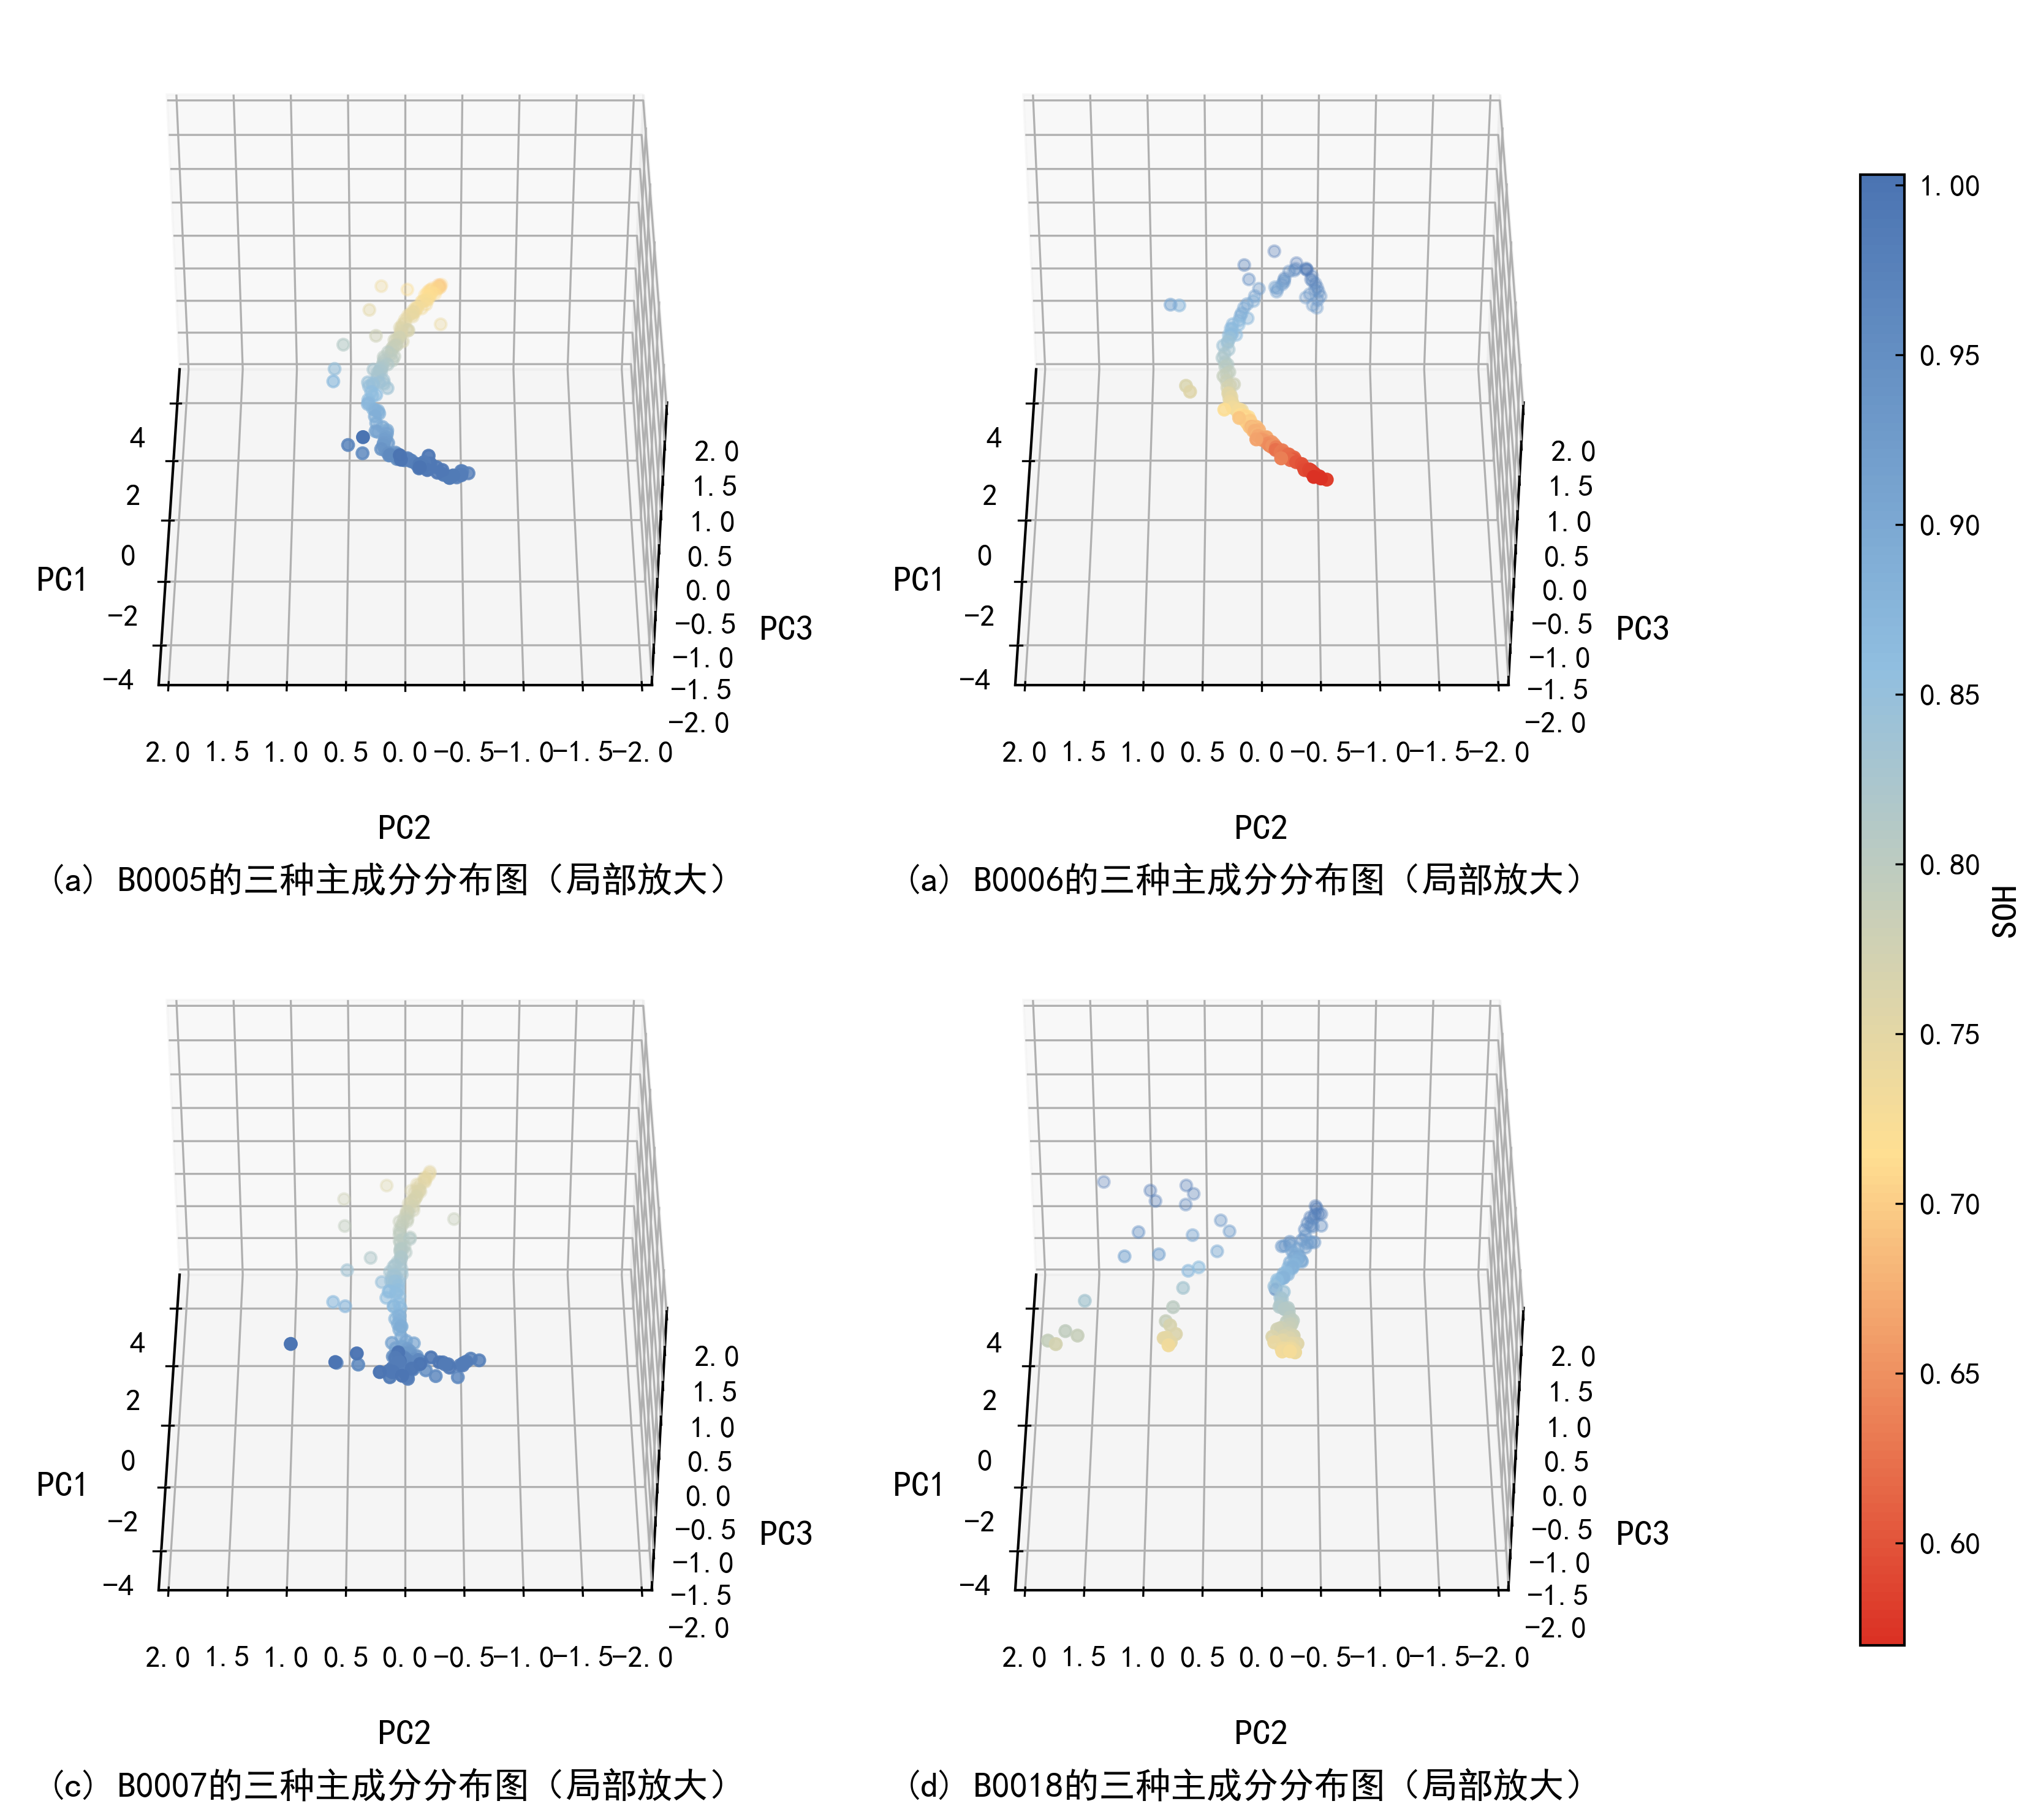

In [87]:
dataframes = [cell1_df, cell2_df, cell3_df, cell4_df]
titles = [
    "(a) B0005的三种主成分分布图（局部放大）", "(a) B0006的三种主成分分布图（局部放大）", "(c) B0007的三种主成分分布图（局部放大）", "(d) B0018的三种主成分分布图（局部放大）"
]

# 首先，确定全局SOH的最小值和最大值

global_soh_min = min(df['SOH'].min() for df in dataframes)
global_soh_max = max(df['SOH'].max() for df in dataframes)
# 创建归一化对象
norm = Normalize(vmin=global_soh_min, vmax=global_soh_max)

fig = SetFig(column=4_3)
colors_rgb = (np.array([
    [75, 116, 178],
    [144, 190, 224],
    [255, 223, 146],
    [219, 49, 36]
])/255.0)[::-1]
cmap_1 = LinearSegmentedColormap.from_list("colors_1", colors_rgb, N=len(cell2_df-1))
# 在创建的子图上绘图
# 示例：使用 axs 属性绘制子图。注意，这需要在调用 set_fig.show() 之前完成
for ax, df, title in zip([fig.ax1, fig.ax2, fig.ax3, fig.ax4], dataframes,
                         titles):
    # 提取特征和标签
    features = df[[
        'dtw_IC','dtw_Vt','ICPeakCharge', 'dv_dt1', 'dv_dt2'
    ]]
    if ax==fig.ax4:     
        features = df[[
            'dtw_IC','ICPeakCharge', 'dv_dt1'
        ]]
    labels = df['SOH']

    # 数据标准化
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 应用PCA，降维到3D
    pca = PCA(n_components=3)
    features_pca = pca.fit_transform(features_scaled)
#     cmap = LinearSegmentedColormap.from_list(cmap,
#                                              colors_rgb,
#                                              N=len(df) - 1)
    cmap = fig.create_cmap(len(df) - 1)
    # 绘制三维散点图
    sc = ax.scatter(features_pca[:, 0],
                    features_pca[:, 1],
                    features_pca[:, 2],
                    c=labels,
                    cmap=cmap_1,
                    norm=norm)

    # 设置轴标签
    ax.set_xlabel('PC1',labelpad=15)
    ax.set_ylabel('PC2',labelpad=15)
    ax.set_zlabel('PC3',labelpad=15)
    ax.set_title(title, y=-0.1)

    #     ax.set_xticks(np.arange(-5,6, 1.0))
    #     ax.set_yticks(np.arange(-2.5,4, 1))
    #     ax.set_zticks(np.arange(-0.5,1.1, 0.5))

    ax.tick_params(axis='x')  # X轴刻度标签字体大小
    ax.tick_params(axis='y')  # Y轴刻度标签字体大小
    ax.tick_params(axis='z')  # Z轴刻度标签字体大小
    # 设置图形的边界为等比例

    ax.set_xlim(-5, 5)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    ax.view_init(elev=40, azim=180)
#     ax.view_init(elev=20, azim=140)

fig.create_colorbar(cmap=cmap_1, norm=norm,label='SOH')

# plt.savefig(r'E:\毕业设计\毕业论文\picture\PCA.svg',
#             format='svg',
#             bbox_inches='tight',
#             )
fig.save('PCA_NASA2')
# fig.show()

In [310]:
## 使用PC1和pc2
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 假设df是你的DataFrame
# df = pd.read_csv('your_dataset.csv')
dataframes = [
    cell1_df, cell2_df, cell3_df, cell4_df
]
battery_names = [
    'B0005', 'B0006', 'B0007', 'B0018'
]  # 电池的名称或标识符
scaler = MinMaxScaler()
pc2_list = {}

save_path = "./output/PC2/"

for df, name in zip(dataframes, battery_names):
    # 选择特征变量，这里假设所有列都是特征
    X = df[['dtw_IC','dtw_Vt','ICPeakCharge', 'dv_dt1', 'dv_dt2']]

    # 标准化特征变量
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 初始化PCA模型，选择主成分个数
    pca = PCA(n_components=3)

    # 拟合PCA模型
    X_pca = pca.fit_transform(X_scaled)

    # 查看主成分解释的方差比例
    print("解释的方差比例: ", pca.explained_variance_ratio_)

    # 将PCA结果转换为DataFrame，便于进一步分析
    pca_df_temp = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2','PC3'])
    MMscaler = MinMaxScaler()

    pca_data_norm = MMscaler.fit_transform(pca_df_temp)
    columns = pca_df_temp.columns
    pca_df = pd.DataFrame(pca_data_norm, columns=columns)
    pca_df['SOH'] = df['SOH'].values
    pca_df['Capacity'] = df['Capacity'].values
    
    pc2_list[name] = pca_df
    filename = os.path.join(save_path, name)
    pca_df.to_csv(filename + '_pca.csv', index=False)
    # 查看PCA结果
    print(pca_df.head())

解释的方差比例:  [0.98521217 0.0106823  0.00223582]
        PC1       PC2       PC3       SOH  Capacity
0  0.025315  0.495212  0.559481  1.000148  1.846327
1  0.053725  0.293927  0.525351  0.994201  1.835349
2  0.048124  0.281146  0.398638  0.994154  1.835263
3  0.055610  0.235061  0.297196  0.993820  1.834646
4  0.060839  0.192517  0.222933  0.994370  1.835662
解释的方差比例:  [0.98176217 0.01534063 0.00162229]
        PC1       PC2       PC3       SOH  Capacity
0  1.000000  0.323583  0.837189  1.000266  2.025140
1  0.981152  0.176630  0.607053  0.994431  2.013326
2  0.969943  0.112042  0.488244  0.994410  2.013285
3  0.976040  0.112146  0.484428  0.988110  2.000528
4  0.970665  0.106213  0.471799  0.994714  2.013899
解释的方差比例:  [0.98381904 0.00906037 0.00489966]
        PC1       PC2       PC3       SOH  Capacity
0  0.008519  0.765246  0.787754  0.998153  1.880637
1  0.074949  0.433065  0.707761  0.998166  1.880663
2  0.064656  0.425007  0.598469  0.998224  1.880771
3  0.064401  0.361728  0.464351  

In [367]:
df = cell4_df
name = 'B0018'
X = df[['dtw_IC','ICPeakCharge','dv_dt1']]

# 标准化特征变量
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 初始化PCA模型，选择主成分个数
pca = PCA(n_components=3)

# 拟合PCA模型
X_pca = pca.fit_transform(X_scaled)

# 查看主成分解释的方差比例
print("解释的方差比例: ", pca.explained_variance_ratio_)

# 将PCA结果转换为DataFrame，便于进一步分析
pca_df_temp = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2','PC3'])
MMscaler = MinMaxScaler()

pca_data_norm = MMscaler.fit_transform(pca_df_temp)
columns = pca_df_temp.columns
pca_df = pd.DataFrame(pca_data_norm, columns=columns)
pca_df['SOH'] = df['SOH'].values
pca_df['Capacity'] = df['Capacity'].values
# pca_df['SOH'] = df['SOH'].values
pearson_corr = pca_df.corr(method='pearson')#kendall、spearman、pearson
print("Pearson相关系数:")
print(pearson_corr)
pearson_corr = pca_df.corr(method='spearman')#kendall、spearman、pearson
print("spearman相关系数:")
print(pearson_corr)
pearson_corr = pca_df.corr(method='kendall')#kendall、spearman、pearson
print("kendall相关系数:")
print(pearson_corr)
pc2_list[name] = pca_df
filename = os.path.join(save_path, name)
# pca_df.to_csv(filename + '_pca.csv', index=False)

解释的方差比例:  [0.90477342 0.09422643 0.00100016]
Pearson相关系数:
                   PC1           PC2           PC3       SOH  Capacity
PC1       1.000000e+00  4.957193e-17 -3.937345e-16  0.990371  0.990371
PC2       4.957193e-17  1.000000e+00 -6.184910e-17 -0.023674 -0.023674
PC3      -3.937345e-16 -6.184910e-17  1.000000e+00 -0.011730 -0.011730
SOH       9.903709e-01 -2.367392e-02 -1.172950e-02  1.000000  1.000000
Capacity  9.903709e-01 -2.367392e-02 -1.172950e-02  1.000000  1.000000
spearman相关系数:
               PC1       PC2       PC3       SOH  Capacity
PC1       1.000000 -0.176875 -0.266845  0.987471  0.987471
PC2      -0.176875  1.000000 -0.085363 -0.209401 -0.209401
PC3      -0.266845 -0.085363  1.000000 -0.296738 -0.296738
SOH       0.987471 -0.209401 -0.296738  1.000000  1.000000
Capacity  0.987471 -0.209401 -0.296738  1.000000  1.000000
kendall相关系数:
               PC1       PC2       PC3       SOH  Capacity
PC1       1.000000 -0.125778 -0.205402  0.920846  0.920846
PC2      -0.12577

In [10]:
# train_df = pd.concat([raw_data1, raw_data2, raw_data4], ignore_index=True)
# test_df = raw_data2
train_df = pd.concat([raw_data3, raw_data2, raw_data4], ignore_index=True)
test_df = raw_data1
# 分割特征和标签
X_train = train_df.drop(columns=['SOH'])
# X = #ICPeakCharge
Y_train = train_df['SOH']
X_test = test_df.drop(columns=['SOH'])
# X = #ICPeakCharge
Y_test = test_df['SOH']
train_df
# print(type(train_df['Cyclecount'][1]))
print(1)
non_int_rows = train_df[train_df['Cyclecount'].apply(lambda x: not isinstance(x, int))]
print(non_int_rows)


1
Empty DataFrame
Columns: [Cyclecount, AvgVoltageCharge, AvgCurrentCharge, AvgTemperatureCharge, VoltageCurrentRatioCharge, ICPeakCharge, SOH]
Index: []


### LightGBM建模

In [ ]:
##lightGBM
# params = {
#     'objective': 'regression',
#     'metric': 'mse',
#     'boosting_type': 'gbdt',
#     'num_leaves': 50,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }
params = {
    'objective': 'regression_l2',
#     'n_estimators': 2000,
    'learning_rate': 0.05,
    'num_leaves':33,
    'min_data_in_leaf': 5,
    'nthread': 5  # 设置线程数，例如4个线程
}

# 初始化用于存储每个折叠的均方误差的列表
mse_scores = []

# 初始化用于存储真实值和预测值的列表
true_values = []
predicted_values = []

# 进行四分交叉验证

# 将数据转换为LightGBM的数据集格式
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test, reference=train_data)

# 训练模型
num_round = 80

callbacks = [early_stopping(stopping_rounds=30)]

start_time = time.time()
# lgbm_model = lgb.train(params,
#                 train_data,
#                 num_round,
#                 valid_sets=[test_data],
#                 callbacks=callbacks);
lgbm_model = lgb.train(params, train_data, num_round, valid_sets=[test_data])
# lgbm_model = lgb.train(params, train_data)
lgbm_time = time.time() - start_time




In [ ]:
# LightGBM
# lgbm_pred = lgbm_model.predict(X_test)
lgbm_pred = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)
lgbm_mse = mean_squared_error(Y_test, lgbm_pred)
print('lgbm_mse:',lgbm_mse)

In [ ]:
plt.figure(figsize=(18, 12))
plt.plot(range(len(Y_test)), Y_test, label='Real Value', marker='o', linestyle='-', color='black')

plt.plot(range(len(lgbm_pred)), lgbm_pred, label='LightGBM Predictions', marker='o', linestyle=':', color='green')

plt.title('Comparison of Model Predictions and Real Values')
plt.xlabel('Sample Index')
plt.ylabel('Predicted/Real Value')
plt.legend()
plt.show()

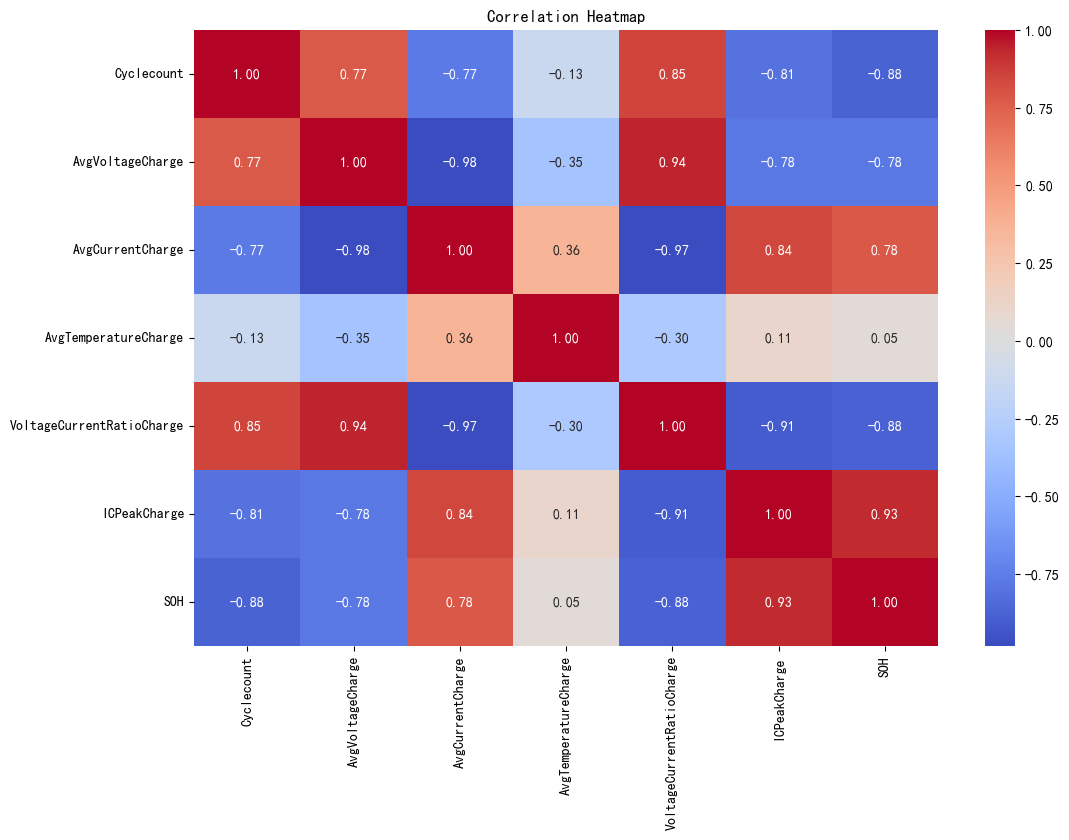

In [11]:
import seaborn as sns

# 计算特征与标签之间的相关性（假设 SOH 列是标签列）
correlation_matrix = train_df.corr()

# 使用热力图可视化相关性矩阵
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### 5. 放电电压 v.s. 充电时间 曲线

In [ ]:
#结果验证
'''
对于比较预测模型的精度，通常使用以下常见的评价标准：

均方根误差（RMSE）：RMSE 表示模型预测值与实际值之间的差异，它对异常值较为敏感。RMSE 越小，模型的预测精度越高。

平均绝对误差（MAE）：MAE 表示模型预测值与实际值之间的绝对差异的平均值。MAE 也用于评估模型的预测性能，尤其是在存在异常值时。

决定系数（R²）：R² 表示模型解释变异性的比例，取值范围在0到1之间。R² 越接近1，模型的性能越好。
'''

# Import necessary libraries
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, Y_train)
xgb_preds = xgb_model.predict(X_test)

# GBDT model
gbdt_model = GradientBoostingRegressor()
gbdt_model.fit(X_train, Y_train)
gbdt_preds = gbdt_model.predict(X_test)

# LightGBM model
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, Y_train)
lgb_preds = lgb_model.predict(X_test)

# Evaluate models
xgb_rmse = mean_squared_error(Y_test, xgb_preds, squared=False)
gbdt_rmse = mean_squared_error(Y_test, gbdt_preds, squared=False)
lgb_rmse = mean_squared_error(Y_test, lgb_preds, squared=False)

xgb_mae = mean_absolute_error(Y_test, xgb_preds)
gbdt_mae = mean_absolute_error(Y_test, gbdt_preds)
lgb_mae = mean_absolute_error(Y_test, lgb_preds)

xgb_r2 = r2_score(Y_test, xgb_preds)
gbdt_r2 = r2_score(Y_test, gbdt_preds)
lgb_r2 = r2_score(Y_test, lgb_preds)

# Print results
print(f"XGBoost RMSE: {xgb_rmse}, MAE: {xgb_mae}, R²: {xgb_r2}")
print(f"GBDT RMSE: {gbdt_rmse}, MAE: {gbdt_mae}, R²: {gbdt_r2}")
print(f"LightGBM RMSE: {lgb_rmse}, MAE: {lgb_mae}, R²: {lgb_r2}")

In [ ]:
def HI_DTW(hi_R,hi,num):
    hi_R = np.array(hi_R).reshape(-1,1)
    hi_R = hi_R[~np.isnan(hi_R).any(axis=1),:]
    hi = np.array(hi).reshape(-1,1)
    hi = hi[~np.isnan(hi).any(axis=1),:]

    manhanttan_distance = lambda x, y : np.abs(x-y)
    d, cost_matrix, acc_cost_matrix, path = dtw(hi_R, hi, dist=manhanttan_distance)
    plt.imshow(acc_cost_matrix.T,origin='lower',cmap='Greys',interpolation='nearest')
    plt.plot(path[0], path[1],label='Cycle'+str(num))
    plt.xlabel('Hi_Refre Sampling Point')
    plt.ylabel('Hi Sampling Point')
    plt.title('Application of DTW to IC curves')
    plt.legend()
    plt.grid()
    plt.show()
    return d

def HI_DTW_(hi_R,hi,num):
    hi_R = np.array(hi_R).reshape(-1,1)
    hi_R = hi_R[~np.isnan(hi_R).any(axis=1),:]
    hi = np.array(hi).reshape(-1,1)
    hi = hi[~np.isnan(hi).any(axis=1),:]

    manhanttan_distance = lambda x, y : np.abs(x-y)
    d, cost_matrix, acc_cost_matrix, path = dtw(hi_R, hi, dist=manhanttan_distance)
    return d

plt.bar(200,HI_DTW_(x,y,200),width=20,label='Cycle'+str(200))
plt.bar(400,HI_DTW_(x,z0,400),width=20,label='Cycle'+str(400))
plt.bar(600,HI_DTW_(x,z1,600),width=20,label='Cycle'+str(600))
plt.bar(800,HI_DTW_(x,z2,800),width=20,label='Cycle'+str(800))
plt.xlabel('Cycle')
plt.ylabel('Distance of DTW')
plt.title('Application of DTW to IC curves')
plt.legend()
plt.grid()
plt.show()